# OpenClassrooms - Ingenieur IA
# Projet 8 - Future Vision Transport 
# Participez à la conception d'une voiture autonome

## Objectif du projet : 
- **Concevoir un premier modèle de segmentation d’images**

## Plan :
- **Identification de la cible**
- **Métrique d'évaluation**
    - Score IoU
    - Temps d'exécution et nombre de paramètres
- **Augmentation des données**
    - Séquence de transformation de l'image
    - Image et masque de test original avant augmentation
    - Essai de deux versions d'augmentation
    - Augmentation de l'image et masque de test original
    - Image et masque de test original après augmentation
- **Générateur de données**
    - Générateur sans augmentation des images
    - Générateur avec augmentation des images à la volée    
- **Mise en place de l'environnement de travail**
    - Création du répertoire du projet
    - Eléments Azure
        - Récupération du Workspace
        - Récupération du Dataset
        - Récupération de l'instance de calcul
        - Récupération de l'environnement
        - Création de l'expérimentation
- **Modélisation**    
    - Modélisation 'from scratch' avec Keras
    - Modélisation avec la librairie 'segmentation-models' 
    - Optimisation des hyper paramètres : 
        - Optimisation de la fonction de perte
        - Optimisation du Backbone
        - Optimisation de l'architecture du réseau
        - Conclusion : meilleur modèle retenu
- **Evaluation du meilleur modèle sur le jeu de test**
    - Récupération du meilleur modèle dans Azure
    - Générateur et pre processing pour le jeu de test
    - Prédictions sur le jeu de test
    - Calcul du Score IoU sur le jeu de test
    - Conclusion de l'évaluation sur le jeu de test

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import tqdm
import math
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

from azureml.core.model import Model

import albumentations as A

import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [4]:
from azureml.core import Workspace
from azureml.core import Experiment
from azureml.core import Environment
from azureml.core import ScriptRunConfig

from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException

from azureml.core.authentication import ServicePrincipalAuthentication

from azureml.core.dataset import Dataset

# Identification de la cible
- L'objectif du projet est de faire de la segmentation d'images, c'est à dire de réaliser un découpage de chaque image originale en différentes catégories prédéfinies
- Pour cela il faut prédire à quelle catégorie appartient chaque pixel de l'image originale
- L'ensemble des prédictions de l'appartenance des pixels aux catégories va former une image que l'on appelle un masque 
- La cible à prédire (également appelé le 'label') est donc le masque de chaque image qui correspond à la catégorie de chaque pixel de l'image 
- Pour chaque image en entrée, il faut donc prédire un masque contenant pour chaque pixel la catégorie correspondante (nature, ciel, humain, )

# Métrique d'évaluation
- La métrique d’évaluation ‘classique’ utilisée dans les problèmes de classification est l’Accuracy. Cette métrique n’est pas adaptée à des jeux de données déséquilibrés comme c’est le cas pour la segmentation d’images
- Nous avons retenu la métrique **Mean IoU Score** pour évaluer les modèles. Ce score correspond à la moyenne du coefficient **Intersection over Union** des différentes catégories. Le coefficient Intersection over Union est défini comme la zone de chevauchement (overlap) entre la segmentation prédite et la segmentation réelle divisé par la zone d’union entre la segmentation prédite et la segmentation réelle.
- La métrique Mean IoU Score est particulièrement bien adaptée à la problématique métier de segmentation d'images
- Le score est compris entre 0 et 1 et plus on s’approche de 1 plus la similarité entre la prédiction et la réalité est élevée


- En plus de cette mesure, nous allons également prendre en compte :
    - Le **Temps d'exécution** des différents modèles
    - Le **Nombre de paramètres** des réseaux des différents modèles

# Augmentation des données
- L'augmentation des données nous permet de générer de nouvelles images à partir des images originales
- Cela permet d'améliorer l'apprentissage
- Nous avons utilisé la librairie Albumentations pour l'augmentation des images


- Nous avons testé **deux types** d'augmentation d'images :
    - Une première version 'légère' qui utilise **trois techniques d'augmentation** :
        - 1 : Horizontal Flip (basculement horizontal de l'image)
        - 2 : Random Gamma (modification aléatoire du gamma)
        - 3 : Blur (ajout de bruit)
        - Chacune des trois techniques d'augmentation a **une probabilité de 0.25 (1 chance sur 4) d'être appliquée**
    - Une seconde version plus 'conséquente' qui utilise **six techniques d'augmentation** :    
        - 1 : Elastic Transform (transformation élastique)
        - 2 : Horizontal Flip (basculement horizontal)
        - 3 : Grid Distortion (distorsion de l'image)
        - 4 : Random Gamma (modification aléatoire du gamma)
        - 5 : Emboss (ciselage de l'image)
        - 6 : Blur (ajout de bruit) 
        - Chacune des six techniques d'augmentation a **une probabilité de 0.5 (1 chance sur 2) d'être appliquée**

- **La seconde version transforme plus les images que la première** : le nombre de modifications et la probabilité d'application sont plus élevés


- Ci-dessous se trouve un essai d'augmentation test sur une image pour chaque version
> ***Remarque : Les augmentations ci-dessous sont des exemples permettant de visualiser les transformations sur un exemple, l'augmentation des images pour la modélisation se fera à la volée dans le générateur de données***

## Image et masque de test original avant augmentation

In [5]:
image = load_img("I:/OCR_IA_P8/cityscape/original_data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png", target_size=(256, 512))

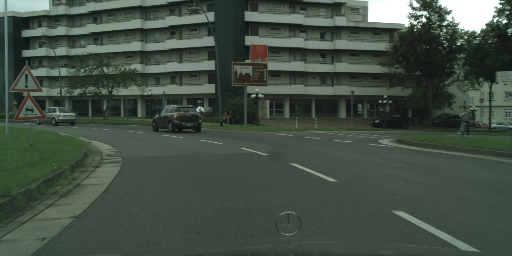

In [6]:
image

In [7]:
mask = load_img("I:/OCR_IA_P8/cityscape/original_data/gtFine/train/aachen/aachen_000000_000019_gtFine_color.png", target_size=(256, 512))

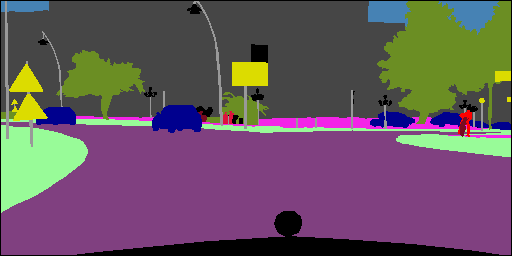

In [8]:
mask

In [9]:
img_array = img_to_array(image)

In [10]:
mask_array = img_to_array(mask)

## Augmentation Version 1

### Séquence de transformation de l'image

In [11]:
transform_v1 = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomGamma(p=1),
    A.Blur(p=1, blur_limit = 7)
])

### Augmentation de l'image et masque de test original

In [12]:
transformed_v1 = transform_v1(image=img_array, mask=mask_array)

In [13]:
transformed_image_array_v1 = transformed_v1['image']

In [14]:
transformed_image_v1 = array_to_img(transformed_image_array_v1)

In [15]:
transformed_mask_array_v1 = transformed_v1['mask']

In [16]:
transformed_mask_v1 = array_to_img(transformed_mask_array_v1)

### Image et masque de test original après augmentation

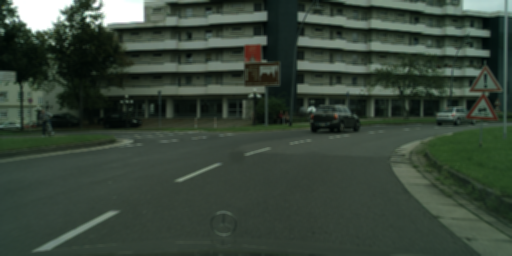

In [15]:
transformed_image_v1

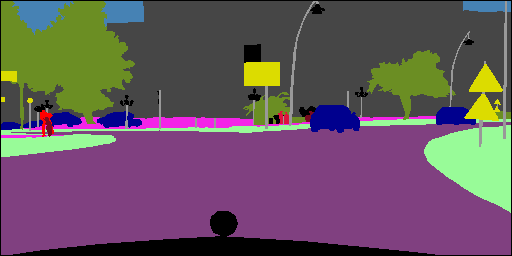

In [16]:
transformed_mask_v1

### Conclusion :
- L'essai d'augmentation d'image a bien fonctionné pusiqu'on remarque sur l'image et le masque de test les transformations appliquées :
    - l'inversion horizontal de l'image
    - un changement de contraste
    - un flou provenant de l'ajout d'un bruit

## Augmentation Version 2

### Séquence de transformation de l'image

In [19]:
transform_v2 = A.Compose([
        A.ElasticTransform(p=1),
        A.HorizontalFlip(p=1),
        A.GridDistortion(p=1),
        A.RandomGamma(p=1),
        A.Emboss(p=1),
        A.Blur(p=1, blur_limit = 7)
])

### Augmentation de l'image et masque de test original

In [20]:
transformed_v2 = transform_v2(image=img_array, mask=mask_array)

In [21]:
transformed_image_array_v2 = transformed_v2['image']

In [22]:
transformed_image_v2 = array_to_img(transformed_image_array_v2)

In [23]:
transformed_mask_array_v2 = transformed_v2['mask']

In [24]:
transformed_mask_v2 = array_to_img(transformed_mask_array_v2)

### Image et masque de test original après augmentation

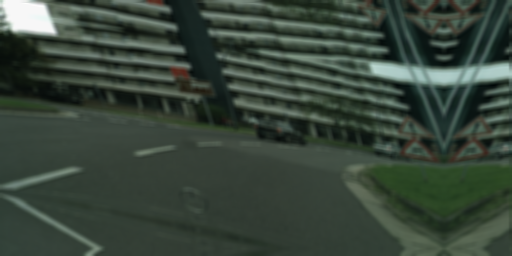

In [23]:
transformed_image_v2

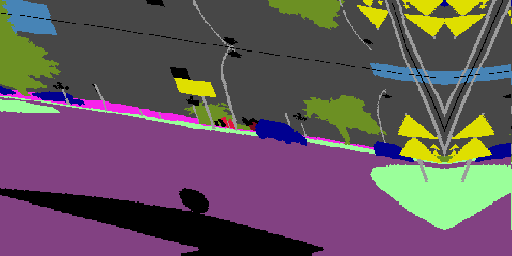

In [24]:
transformed_mask_v2

### Conclusion :
- L'essai d'augmentation d'image a bien fonctionné et on remarque que les transformations sont plus conséquentes que la précédente version

# Générateur de données
- Le générateur de données va permettre de générer des images à la volée en batch
- Cela permet de traiter des données volumineuses comme c'est le cas pour les images
- Cela permet d'utiliser plusieurs processeurs sur une machine
- Pour implémenter un générateur de données sur mesure, nous dérivons la class Keras 'Sequence'
- La normalisation des données est également effectuée dans le générateur de données
> ***Remarque : Les générateurs de données ci-dessous sont à titre d'illustration, les générateurs utilisés pour la modélisation sont incorporés dans les scripts envoyés à Azure pour l'entrainement des modèles***

## Générateur sans augmentation des images

In [27]:
class DataGeneratorKeras(Sequence):

    def __init__(self, batch_size, img_size, input_img_dir, target_img_dir):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_dir = input_img_dir
        self.input_img_paths = os.listdir(input_img_dir)
        self.target_img_dir = target_img_dir
        self.target_img_paths = os.listdir(target_img_dir)

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        #traitement des images
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, input_path in enumerate(batch_input_img_paths):
            img = load_img(os.path.join(self.input_img_dir, input_path), target_size=self.img_size)
            img_array = img_to_array(img)
            x[j] = img_array / 255. #normalisation des données
        
        #traitement des masques
        y = np.zeros((self.batch_size,) + self.img_size + (8,), dtype="float32")
        for j, target_path in enumerate(batch_target_img_paths):
            mask = load_img(os.path.join(self.target_img_dir, target_path), target_size=self.img_size, color_mode="grayscale")
            mask_array = img_to_array(mask)
            y[j] = tf.one_hot(np.squeeze(mask_array), 8, on_value=1.0, off_value=0.0, axis=-1)
        
        return x, y

## Générateur avec augmentation des images à la volée
- L'augmenteur de données est créé grâce à la librairie Albumentations et transmis en paramètre du générateur

In [28]:
class DataGeneratorKeras(Sequence):

    def __init__(self, batch_size, img_size, input_img_dir, target_img_dir, augmentation_sequence=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_dir = input_img_dir
        self.input_img_paths = os.listdir(input_img_dir)
        self.target_img_dir = target_img_dir
        self.target_img_paths = os.listdir(target_img_dir)
        self.augmentation_sequence = augmentation_sequence

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
                
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (8,), dtype="float32")
        
        if self.augmentation_sequence is not None:
            for j in range(len(batch_input_img_paths)):
                #traitement des images
                input_path = batch_input_img_paths[j]
                img = load_img(os.path.join(self.input_img_dir, input_path), target_size=self.img_size)
                img_array = img_to_array(img)

                #traitement des masques
                target_path = batch_target_img_paths[j]
                mask = load_img(os.path.join(self.target_img_dir, target_path), target_size=self.img_size, color_mode="grayscale")
                mask_array = img_to_array(mask)
                
                augmented_data = self.augmentation_sequence(image=img_array, mask=mask_array)

                x[j] = augmented_data['image'] / 255. #normalisation des données
                y[j] = tf.one_hot(np.squeeze(augmented_data['mask']), 8, on_value=1.0, off_value=0.0, axis=-1)
        
        else:
            #traitement des images
            for j, input_path in enumerate(batch_input_img_paths):
                img = load_img(os.path.join(self.input_img_dir, input_path), target_size=self.img_size)
                img_array = img_to_array(img)
                x[j] = img_array / 255. #normalisation des données
        
            #traitement des masques
            for j, target_path in enumerate(batch_target_img_paths):
                mask = load_img(os.path.join(self.target_img_dir, target_path), target_size=self.img_size, color_mode="grayscale")
                mask_array = img_to_array(mask)
                y[j] = tf.one_hot(np.squeeze(mask_array), 8, on_value=1.0, off_value=0.0, axis=-1)
        
        return x, y

# Mise en place de l'environnement de travail

## Répertoire de travail

In [29]:
project_folder = './cityscape_project/scripts_azure'

## Eléments Azure

### Récupération du Workpsace Azure : authentification utilisant le service recommandé 'Service Principal Authentication'

In [30]:
svc_pr_password = os.environ['CITYSCAPE_SPA_PASSWORD']
tenant_id = '894ad120-c276-4dfa-b218-d82b3fece6a7'
application_id = '21cf902f-1dc0-459d-b352-b7490946f6c6'

In [31]:
svc_pr = ServicePrincipalAuthentication(
        tenant_id=tenant_id,
        service_principal_id=application_id,
        service_principal_password=svc_pr_password)

In [32]:
subscription_id = subscription_id = os.environ['AZURE_SUBSCRIPTION_ID']
resource_group = 'OC-IA-P8-GPU'
workspace_name = 'WS-IA-P8-GPU'
ws = Workspace(
        subscription_id=subscription_id,
        resource_group=resource_group,
        workspace_name=workspace_name,
        auth=svc_pr)

In [33]:
print(ws.name, ws.location, ws.resource_group, sep='\t')

WS-IA-P8-GPU	eastus	OC-IA-P8-GPU


### Récupération du Dataset

In [34]:
dataset_prepared_name = "dataset_cityscape_prepared"

In [35]:
dataset_prepared = Dataset.get_by_name(workspace = ws, name = dataset_prepared_name)

In [36]:
dataset_prepared

{
  "source": [
    "('datastore_cityscape_prepared', 'prepared_data/')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ],
  "registration": {
    "id": "04ea4a17-f1ee-4144-a1b2-d352f7bf27f6",
    "name": "dataset_cityscape_prepared",
    "version": 1,
    "description": "Dataset pour le projet Cityscape",
    "workspace": "Workspace.create(name='WS-IA-P8-GPU', subscription_id='dc0050bb-8e50-4b60-8aac-034371ba1a2a', resource_group='OC-IA-P8-GPU')"
  }
}

### Récupération de l'instance de calcul

In [37]:
compute_name = 'obonheur1'

In [38]:
try:
    compute = ComputeTarget(workspace=ws, name = compute_name)
    print('Instance de calcul trouvée')
except ComputeTargetException:
    print('ERREUR : Instance de calcul non trouvée')

Instance de calcul trouvée


In [39]:
print(compute.get_status().serialize())

{'errors': [], 'creationTime': '2021-09-08T10:10:16.266650+00:00', 'createdBy': {'userObjectId': '834dd19c-005b-41ce-b292-6dd784dd0cdd', 'userTenantId': '894ad120-c276-4dfa-b218-d82b3fece6a7', 'userName': None}, 'modifiedTime': '2021-10-06T12:52:44.201125+00:00', 'state': 'Stopped', 'vmSize': 'STANDARD_NC6_PROMO'}


### Récupération de l'environnement Python

In [40]:
environment_name="cityscape-environment"

In [41]:
environment = Environment.get(workspace = ws, name = environment_name)

In [42]:
environment

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04:20210906.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": true,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "cityscape-environment",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "conda-forge"
     

# Modélisation
- Les modélisations que nous avons implémentées peuvent être regroupées en 2 catégories :
    - Modélisation **'from scratch'** : les modèles sont implémentés ‘à la main’ en utilisant l'API fonctionnelle de Keras
>Cette première approche permet de bien comprendre et appréhender les modèles et l'API Keras

    - Modélisation utilisant la librairie **'segmentation-models'** : cette librairie Python, qui s’appuie sur Keras, contient des modèles, des métriques et des fonctions de coût dédiés à la segmentation
> Cette seconde approche permet d'utiliser des modèles plus avancés, ainsi que des fonctions de coût différentes déjà implémentées


- Pour l'entraînement des modèles nous avons réduit la taille des images afin d'avoir des temps de calcul raisonnable et également pour tenir compte de la capacité mémoire du matériel qui nous est alloué

### Fonction permettant de tracer les courbes de Loss / Validation Loss et IoU Score / Validation IoU Score en fonction du nombre d'epochs

In [43]:
def plot_results(metrics): 
    plt.figure()
    plt.plot(metrics['Loss'])
    plt.plot(metrics['Validation Loss'])
    plt.legend(['Train', 'Validation'])
    plt.title("Evolution de la Loss en fonction du nombre d'epochs")
    plt.show()
    plt.figure()
    plt.plot(metrics['IoU Score'])
    plt.plot(metrics['Validation IoU Score'])
    plt.legend(['Train', 'Validation'])
    plt.title("Evolution du Score IoU en fonction du nombre d'epochs")
    plt.show()

In [44]:
script_arguments = ['--data-path', dataset_prepared.as_mount()]

## Modélisation 'from scratch' en utilisant Keras

### 1 - Modèle : Architecture Simple - Fonction de perte CategoricalCrossEntropy - Sans d'augmentation des données
- Ce modèle a une architecture simple qui est une suite de couches de convolution pour la partie downsampling, enchaîné avec une suite de couches de convolution transposées pour la partie upsampling
- Il nous servira de **modèle de référence (baseline)**

#### Création de l'expérimentation

In [43]:
experiment_name = '1_cityscape_fs_simple'

In [44]:
experiment = Experiment(workspace=ws, name=experiment_name)

#### Lancement du script

In [45]:
script_arguments = ['--data-path', dataset_prepared.as_mount()]

In [46]:
src = ScriptRunConfig(source_directory=project_folder, 
                      script='1_train_fs_simple.py',
                      arguments=script_arguments,
                      compute_target=compute, 
                      environment=environment)

In [47]:
run_1 = experiment.submit(config=src)

In [48]:
run_1

Experiment,Id,Type,Status,Details Page,Docs Page
1_cityscape_fs_simple,1_cityscape_fs_simple_1633343903_6c84a9f6,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [49]:
%%time
run_1.wait_for_completion(show_output=True)

RunId: 1_cityscape_fs_simple_1633343903_6c84a9f6
Web View: https://ml.azure.com/runs/1_cityscape_fs_simple_1633343903_6c84a9f6?wsid=/subscriptions/dc0050bb-8e50-4b60-8aac-034371ba1a2a/resourcegroups/OC-IA-P8-GPU/workspaces/WS-IA-P8-GPU&tid=894ad120-c276-4dfa-b218-d82b3fece6a7

Streaming azureml-logs/55_azureml-execution-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

2021-10-04T10:38:37Z Running following command: /bin/bash -c sudo blobfuse /mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/1_cityscape_fs_simple_1633343903_6c84a9f6/mounts/workspaceblobstore --tmp-path=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/1_cityscape_fs_simple_1633343903_6c84a9f6/caches/workspaceblobstore -o ro --file-cache-timeout-in-seconds=1000000 --cache-size-mb=260245 -o nonempty -o allow_other --config-file=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/1_cityscape_fs_simple_1633343903_6c84a9f6/configs/workspaceblobstore.cfg --log-level=LOG_WARNI

Epoch 1/20
2021-10-04 10:39:19.632307: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-10-04 10:39:20.281188: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10

74/74 [==============================] - ETA: 0s - loss: 1.7950 - iou_score: 0.0719
Epoch 00001: val_loss improved from inf to 1.37428, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 492s 7s/step - loss: 1.7950 - iou_score: 0.0719 - val_loss: 1.3743 - val_iou_score: 0.1046
Epoch 2/20

25/74 [=========>....................] - ETA: 3:42 - loss: 1.3186 - iou_score: 0.1280


74/74 [==============================] - ETA: 0s - loss: 1.1904 - iou_score: 0.1553
Epoch 00002: val_loss improved from 1.37428 to 0.93599, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 480s 6s/step - loss: 1.1904 - iou_score: 0.1553 - val_loss: 0.9360 - val_iou_score: 0.2102
Epoch 3/20

47/74 [==================>...........] - ETA: 2:21 - loss: 0.9412 - iou_score: 0.2429


74/74 [==============================] - ETA: 0s - loss: 0.9288 - iou_score: 0.2479
Epoch 00003: val_loss improved from 0.93599 to 0.92564, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 489s 7s/step - loss: 0.9288 - iou_score: 0.2479 - val_loss: 0.9256 - val_iou_score: 0.2515
Epoch 4/20

74/74 [==============================] - ETA: 0s - loss: 0.8962 - iou_score: 0.2628


Epoch 00004: val_loss improved from 0.92564 to 0.86093, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 504s 7s/step - loss: 0.8962 - iou_score: 0.2628 - val_loss: 0.8609 - val_iou_score: 0.2532
Epoch 5/20

74/74 [==============================] - ETA: 0s - loss: 0.8671 - iou_score: 0.2755
Epoch 00005: val_loss improved from 0.86093 to 0.80094, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 518s 7s/step - loss: 0.8671 - iou_score: 0.2755 - val_loss: 0.8009 - val_iou_score: 0.2945
Epoch 6/20

24/74 [========>.....................] - ETA: 4:09 - loss: 0.8263 - iou_score: 0.2980


74/74 [==============================] - ETA: 0s - loss: 0.8053 - iou_score: 0.3056
Epoch 00006: val_loss improved from 0.80094 to 0.73195, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 499s 7s/step - loss: 0.8053 - iou_score: 0.3056 - val_loss: 0.7319 - val_iou_score: 0.3402
Epoch 7/20

44/74 [================>.............] - ETA: 2:38 - loss: 0.7304 - iou_score: 0.3325


74/74 [==============================] - ETA: 0s - loss: 0.7596 - iou_score: 0.3235
Epoch 00007: val_loss improved from 0.73195 to 0.70316, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 500s 7s/step - loss: 0.7596 - iou_score: 0.3235 - val_loss: 0.7032 - val_iou_score: 0.3311
Epoch 8/20

70/74 [===========================>..] - ETA: 21s - loss: 0.6847 - iou_score: 0.3612


74/74 [==============================] - ETA: 0s - loss: 0.6850 - iou_score: 0.3611
Epoch 00008: val_loss improved from 0.70316 to 0.67121, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 505s 7s/step - loss: 0.6850 - iou_score: 0.3611 - val_loss: 0.6712 - val_iou_score: 0.3524
Epoch 9/20

74/74 [==============================] - ETA: 0s - loss: 0.6569 - iou_score: 0.3758
Epoch 00009: val_loss improved from 0.67121 to 0.58506, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 507s 7s/step - loss: 0.6569 - iou_score: 0.3758 - val_loss: 0.5851 - val_iou_score: 0.3898
Epoch 10/20

21/74 [=======>......................] - ETA: 4:13 - loss: 0.6154 - iou_score: 0.3951


74/74 [==============================] - ETA: 0s - loss: 0.5981 - iou_score: 0.4063
Epoch 00010: val_loss improved from 0.58506 to 0.53703, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 488s 7s/step - loss: 0.5981 - iou_score: 0.4063 - val_loss: 0.5370 - val_iou_score: 0.4217
Epoch 11/20

44/74 [================>.............] - ETA: 2:33 - loss: 0.5722 - iou_score: 0.4185


74/74 [==============================] - ETA: 0s - loss: 0.5763 - iou_score: 0.4167
Epoch 00011: val_loss improved from 0.53703 to 0.52828, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 489s 7s/step - loss: 0.5763 - iou_score: 0.4167 - val_loss: 0.5283 - val_iou_score: 0.4199
Epoch 12/20

66/74 [=========================>....] - ETA: 42s - loss: 0.5793 - iou_score: 0.4175


74/74 [==============================] - ETA: 0s - loss: 0.5760 - iou_score: 0.4181
Epoch 00012: val_loss did not improve from 0.52828

74/74 [==============================] - 485s 7s/step - loss: 0.5760 - iou_score: 0.4181 - val_loss: 0.5310 - val_iou_score: 0.4239
Epoch 13/20

74/74 [==============================] - ETA: 0s - loss: 0.5406 - iou_score: 0.4318
Epoch 00013: val_loss improved from 0.52828 to 0.47366, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 486s 7s/step - loss: 0.5406 - iou_score: 0.4318 - val_loss: 0.4737 - val_iou_score: 0.4600
Epoch 14/20

11/74 [===>..........................] - ETA: 4:29 - loss: 0.5426 - iou_score: 0.4285


74/74 [==============================] - ETA: 0s - loss: 0.5308 - iou_score: 0.4389
Epoch 00014: val_loss did not improve from 0.47366

74/74 [==============================] - 485s 7s/step - loss: 0.5308 - iou_score: 0.4389 - val_loss: 0.4873 - val_iou_score: 0.4532
Epoch 15/20

35/74 [=============>................] - ETA: 3:10 - loss: 0.5089 - iou_score: 0.4558


74/74 [==============================] - ETA: 0s - loss: 0.5053 - iou_score: 0.4562
Epoch 00015: val_loss improved from 0.47366 to 0.44910, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 477s 6s/step - loss: 0.5053 - iou_score: 0.4562 - val_loss: 0.4491 - val_iou_score: 0.4774
Epoch 16/20

59/74 [======================>.......] - ETA: 1:17 - loss: 0.4859 - iou_score: 0.4689


74/74 [==============================] - ETA: 0s - loss: 0.4867 - iou_score: 0.4687
Epoch 00016: val_loss did not improve from 0.44910

74/74 [==============================] - 479s 6s/step - loss: 0.4867 - iou_score: 0.4687 - val_loss: 0.4622 - val_iou_score: 0.4651
Epoch 17/20

74/74 [==============================] - ETA: 0s - loss: 0.4784 - iou_score: 0.4730
Epoch 00017: val_loss improved from 0.44910 to 0.44037, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 473s 6s/step - loss: 0.4784 - iou_score: 0.4730 - val_loss: 0.4404 - val_iou_score: 0.4732
Epoch 18/20

 5/74 [=>............................] - ETA: 4:36 - loss: 0.4372 - iou_score: 0.4850


74/74 [==============================] - ETA: 0s - loss: 0.4830 - iou_score: 0.4698
Epoch 00018: val_loss did not improve from 0.44037

74/74 [==============================] - 500s 7s/step - loss: 0.4830 - iou_score: 0.4698 - val_loss: 0.4452 - val_iou_score: 0.4659
Epoch 19/20

32/74 [===========>..................] - ETA: 4:03 - loss: 0.4672 - iou_score: 0.4791


74/74 [==============================] - ETA: 0s - loss: 0.4570 - iou_score: 0.4858
Epoch 00019: val_loss improved from 0.44037 to 0.42104, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 547s 7s/step - loss: 0.4570 - iou_score: 0.4858 - val_loss: 0.4210 - val_iou_score: 0.4886
Epoch 20/20

52/74 [====================>.........] - ETA: 2:10 - loss: 0.4506 - iou_score: 0.4880


74/74 [==============================] - ETA: 0s - loss: 0.4485 - iou_score: 0.4913

Streaming azureml-logs/75_job_post-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

[2021-10-04T13:26:50.265169] Entering job release
[2021-10-04T13:26:51.056981] Starting job release
[2021-10-04T13:26:51.057395] Logging experiment finalizing status in history service.
Starting the daemon thread to refresh tokens in background for process with pid = 1301[2021-10-04T13:26:51.057643] job release stage : upload_datastore starting...

[2021-10-04T13:26:51.059858] job release stage : start importing azureml.history._tracking in run_history_release.
[2021-10-04T13:26:51.060113] job release stage : execute_job_release starting...[2021-10-04T13:26:51.060242] job release stage : copy_batchai_cached_logs starting...

[2021-10-04T13:26:51.060403] job release stage : copy_batchai_cached_logs completed...
[2021-10-04T13:26:51.071355] Entering context manager injector.
[2021-10-04T13:26:

{'runId': '1_cityscape_fs_simple_1633343903_6c84a9f6',
 'target': 'obonheur1',
 'status': 'Completed',
 'startTimeUtc': '2021-10-04T10:38:36.696484Z',
 'endTimeUtc': '2021-10-04T13:27:04.702191Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'f8ba4d08-d08d-4d49-ab9c-800ade6ab97e',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '04ea4a17-f1ee-4144-a1b2-d352f7bf27f6'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__04ea4a17', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': '1_train_fs_simple.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-path', 'DatasetConsumptionConfig:input__04ea4a17'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'obonheur1',
  'dataReferences': {},
  'data': {'input__04ea4a17': {'data

#### Résultats

In [50]:
metrics_1 = run_1.get_metrics()

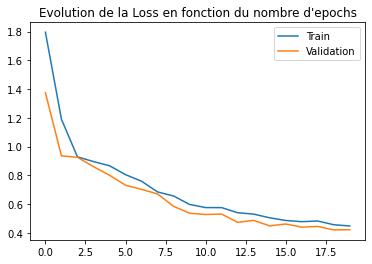

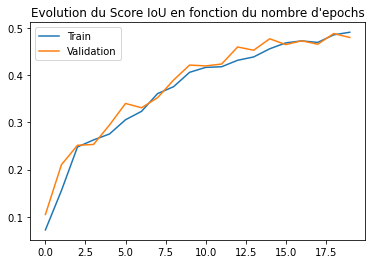

In [52]:
plot_results(metrics_1)

In [51]:
print('Nombre de paramètres du réseau : ', metrics_1['Nombre de paramètres'][0])

Nombre de paramètres du réseau :  2883528


#### Temps de calcul = 2h 48mns

#### Conclusion :
- Ce modèle très simple donne des résultats déjà interessants
- Le score IoU sur le jeu de validation est de 0.48
- Il n'y a pas d'overfitting
> **Nous allons essayer de l'améliorer**

### 2 - Modèle : Architecture Simple - Fonction de perte CategoricalCrossEntropy - Avec augmentation des données Version 1
- Dans ce modèle, nous avons ajouté la première version de l'augmentation d'images

#### Création de l'expérimentation

In [55]:
experiment_name = '2_cityscape_fs_simple_aug'

In [56]:
experiment = Experiment(workspace=ws, name=experiment_name)

#### Lancement du script

In [57]:
script_arguments = ['--data-path', dataset_prepared.as_mount()]

In [60]:
src = ScriptRunConfig(source_directory=project_folder, 
                      script='2_train_fs_simple_augv1.py',
                      arguments=script_arguments,
                      compute_target=compute, 
                      environment=environment)

In [61]:
run_2 = experiment.submit(config=src)

In [62]:
run_2

Experiment,Id,Type,Status,Details Page,Docs Page
2_cityscape_fs_simple_aug,2_cityscape_fs_simple_aug_1633354370_08365366,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [63]:
%%time
run_2.wait_for_completion(show_output=True)

RunId: 2_cityscape_fs_simple_aug_1633354370_08365366
Web View: https://ml.azure.com/runs/2_cityscape_fs_simple_aug_1633354370_08365366?wsid=/subscriptions/dc0050bb-8e50-4b60-8aac-034371ba1a2a/resourcegroups/OC-IA-P8-GPU/workspaces/WS-IA-P8-GPU&tid=894ad120-c276-4dfa-b218-d82b3fece6a7

Streaming azureml-logs/55_azureml-execution-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

2021-10-04T13:33:08Z Running following command: /bin/bash -c sudo blobfuse /mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/2_cityscape_fs_simple_aug_1633354370_08365366/mounts/workspaceblobstore --tmp-path=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/2_cityscape_fs_simple_aug_1633354370_08365366/caches/workspaceblobstore -o ro --file-cache-timeout-in-seconds=1000000 --cache-size-mb=260244 -o nonempty -o allow_other --config-file=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/2_cityscape_fs_simple_aug_1633354370_08365366/configs/workspaceblobstore.cfg -

Epoch 1/20
2021-10-04 13:33:46.675784: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-10-04 13:33:47.307345: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10

74/74 [==============================] - ETA: 0s - loss: 1.8163 - iou_score: 0.0663
Epoch 00001: val_loss improved from inf to 1.47417, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 483s 7s/step - loss: 1.8163 - iou_score: 0.0663 - val_loss: 1.4742 - val_iou_score: 0.0934
Epoch 2/20

26/74 [=========>....................] - ETA: 3:33 - loss: 1.4601 - iou_score: 0.1048


74/74 [==============================] - ETA: 0s - loss: 1.2844 - iou_score: 0.1312
Epoch 00002: val_loss improved from 1.47417 to 1.00810, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 485s 7s/step - loss: 1.2844 - iou_score: 0.1312 - val_loss: 1.0081 - val_iou_score: 0.1852
Epoch 3/20

49/74 [==================>...........] - ETA: 2:09 - loss: 1.0250 - iou_score: 0.1977


74/74 [==============================] - ETA: 0s - loss: 0.9958 - iou_score: 0.2113
Epoch 00003: val_loss improved from 1.00810 to 0.87011, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 494s 7s/step - loss: 0.9958 - iou_score: 0.2113 - val_loss: 0.8701 - val_iou_score: 0.2695
Epoch 4/20

73/74 [============================>.] - ETA: 5s - loss: 0.8888 - iou_score: 0.2689 


74/74 [==============================] - ETA: 0s - loss: 0.8868 - iou_score: 0.2694
Epoch 00004: val_loss did not improve from 0.87011

74/74 [==============================] - 489s 7s/step - loss: 0.8868 - iou_score: 0.2694 - val_loss: 0.9497 - val_iou_score: 0.2638
Epoch 5/20

74/74 [==============================] - ETA: 0s - loss: 0.8181 - iou_score: 0.2991
Epoch 00005: val_loss improved from 0.87011 to 0.78808, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 473s 6s/step - loss: 0.8181 - iou_score: 0.2991 - val_loss: 0.7881 - val_iou_score: 0.2893
Epoch 6/20

21/74 [=======>......................] - ETA: 3:44 - loss: 0.8033 - iou_score: 0.3037


74/74 [==============================] - ETA: 0s - loss: 0.7833 - iou_score: 0.3165
Epoch 00006: val_loss improved from 0.78808 to 0.72947, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 466s 6s/step - loss: 0.7833 - iou_score: 0.3165 - val_loss: 0.7295 - val_iou_score: 0.3344
Epoch 7/20

42/74 [================>.............] - ETA: 2:33 - loss: 0.7144 - iou_score: 0.3462


74/74 [==============================] - ETA: 0s - loss: 0.7086 - iou_score: 0.3518
Epoch 00007: val_loss improved from 0.72947 to 0.67580, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 460s 6s/step - loss: 0.7086 - iou_score: 0.3518 - val_loss: 0.6758 - val_iou_score: 0.3457
Epoch 8/20

72/74 [============================>.] - ETA: 9s - loss: 0.7058 - iou_score: 0.3524 


74/74 [==============================] - ETA: 0s - loss: 0.7056 - iou_score: 0.3529
Epoch 00008: val_loss did not improve from 0.67580

74/74 [==============================] - 457s 6s/step - loss: 0.7056 - iou_score: 0.3529 - val_loss: 0.6800 - val_iou_score: 0.3472
Epoch 9/20

74/74 [==============================] - ETA: 0s - loss: 0.6431 - iou_score: 0.3832
Epoch 00009: val_loss improved from 0.67580 to 0.61331, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 463s 6s/step - loss: 0.6431 - iou_score: 0.3832 - val_loss: 0.6133 - val_iou_score: 0.3731
Epoch 10/20

26/74 [=========>....................] - ETA: 3:33 - loss: 0.6049 - iou_score: 0.3944


74/74 [==============================] - ETA: 0s - loss: 0.6036 - iou_score: 0.4028
Epoch 00010: val_loss improved from 0.61331 to 0.56447, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 459s 6s/step - loss: 0.6036 - iou_score: 0.4028 - val_loss: 0.5645 - val_iou_score: 0.4136
Epoch 11/20

53/74 [====================>.........] - ETA: 1:45 - loss: 0.5601 - iou_score: 0.4249


74/74 [==============================] - ETA: 0s - loss: 0.5803 - iou_score: 0.4159
Epoch 00011: val_loss did not improve from 0.56447

74/74 [==============================] - 470s 6s/step - loss: 0.5803 - iou_score: 0.4159 - val_loss: 0.5881 - val_iou_score: 0.4195
Epoch 12/20

74/74 [==============================] - ETA: 0s - loss: 0.5600 - iou_score: 0.4266


Epoch 00012: val_loss improved from 0.56447 to 0.52061, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 473s 6s/step - loss: 0.5600 - iou_score: 0.4266 - val_loss: 0.5206 - val_iou_score: 0.4445
Epoch 13/20

74/74 [==============================] - ETA: 0s - loss: 0.5347 - iou_score: 0.4429
Epoch 00013: val_loss improved from 0.52061 to 0.47757, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 480s 6s/step - loss: 0.5347 - iou_score: 0.4429 - val_loss: 0.4776 - val_iou_score: 0.4548
Epoch 14/20

21/74 [=======>......................] - ETA: 4:15 - loss: 0.5091 - iou_score: 0.4571


74/74 [==============================] - ETA: 0s - loss: 0.5054 - iou_score: 0.4584
Epoch 00014: val_loss did not improve from 0.47757

74/74 [==============================] - 481s 7s/step - loss: 0.5054 - iou_score: 0.4584 - val_loss: 0.4964 - val_iou_score: 0.4436
Epoch 15/20

47/74 [==================>...........] - ETA: 2:21 - loss: 0.5071 - iou_score: 0.4536


74/74 [==============================] - ETA: 0s - loss: 0.5068 - iou_score: 0.4563
Epoch 00015: val_loss improved from 0.47757 to 0.46900, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 491s 7s/step - loss: 0.5068 - iou_score: 0.4563 - val_loss: 0.4690 - val_iou_score: 0.4622
Epoch 16/20

74/74 [==============================] - ETA: 0s - loss: 0.4831 - iou_score: 0.4698


Epoch 00016: val_loss improved from 0.46900 to 0.45658, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 490s 7s/step - loss: 0.4831 - iou_score: 0.4698 - val_loss: 0.4566 - val_iou_score: 0.4784
Epoch 17/20

74/74 [==============================] - ETA: 0s - loss: 0.4772 - iou_score: 0.4740
Epoch 00017: val_loss improved from 0.45658 to 0.45585, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 478s 6s/step - loss: 0.4772 - iou_score: 0.4740 - val_loss: 0.4559 - val_iou_score: 0.4631
Epoch 18/20

24/74 [========>.....................] - ETA: 3:39 - loss: 0.4510 - iou_score: 0.4860


74/74 [==============================] - ETA: 0s - loss: 0.4653 - iou_score: 0.4773
Epoch 00018: val_loss improved from 0.45585 to 0.44309, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 478s 6s/step - loss: 0.4653 - iou_score: 0.4773 - val_loss: 0.4431 - val_iou_score: 0.4860
Epoch 19/20

50/74 [===================>..........] - ETA: 2:00 - loss: 0.4464 - iou_score: 0.4911


74/74 [==============================] - ETA: 0s - loss: 0.4451 - iou_score: 0.4930
Epoch 00019: val_loss improved from 0.44309 to 0.42800, saving model to cityscape-fs-simple.h5

74/74 [==============================] - 485s 7s/step - loss: 0.4451 - iou_score: 0.4930 - val_loss: 0.4280 - val_iou_score: 0.4928
Epoch 20/20

74/74 [==============================] - ETA: 0s - loss: 0.4351 - iou_score: 0.4993



Streaming azureml-logs/75_job_post-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

[2021-10-04T16:14:56.019703] Entering job release
[2021-10-04T16:14:56.802401] Starting job release
[2021-10-04T16:14:56.802823] Logging experiment finalizing status in history service.
[2021-10-04T16:14:56.803518] job release stage : upload_datastore starting...Starting the daemon thread to refresh tokens in background for process with pid = 1251[2021-10-04T16:14:56.803793] job release stage : start importing azureml.history._tracking in run_history_release.

[2021-10-04T16:14:56.803932] job release stage : execute_job_release starting...
[2021-10-04T16:14:56.804151] job release stage : copy_batchai_cached_logs starting...

[2021-10-04T16:14:56.804393] job release stage : copy_batchai_cached_logs completed...
[2021-10-04T16:14:56.817657] Entering context manager injector.
[2021-10-04T16:14:56.822094] job release stage : upload_datastore completed...
[2021-10-04T16:14:56.90

{'runId': '2_cityscape_fs_simple_aug_1633354370_08365366',
 'target': 'obonheur1',
 'status': 'Completed',
 'startTimeUtc': '2021-10-04T13:33:07.739476Z',
 'endTimeUtc': '2021-10-04T16:15:08.396525Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'f8ba4d08-d08d-4d49-ab9c-800ade6ab97e',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '04ea4a17-f1ee-4144-a1b2-d352f7bf27f6'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__04ea4a17', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': '2_train_fs_simple_augv1.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-path', 'DatasetConsumptionConfig:input__04ea4a17'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'obonheur1',
  'dataReferences': {},
  'data': {'input__04ea4a1

#### Résultats

In [64]:
metrics_2 = run_2.get_metrics()

In [65]:
print('Nombre de paramètres du réseau : ', metrics_2['Nombre de paramètres'][0])

Nombre de paramètres du réseau :  2883528


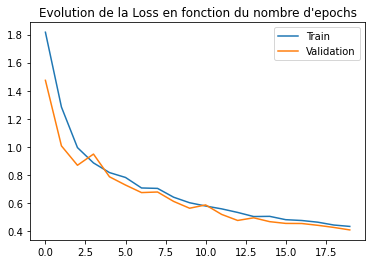

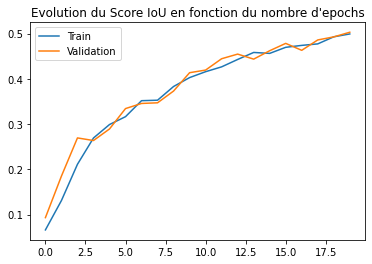

In [66]:
plot_results(metrics_2)

In [67]:
print('Nombre de paramètres du réseau : ', metrics_2['Nombre de paramètres'][0])

Nombre de paramètres du réseau :  2883528


#### Temps de calcul = 2h 42mns

#### Conclusion :
- Ce modèle est meilleur que le précédent
- Le score IoU sur le jeu de validation a progressé à 0.5
- Il n'y a pas d'overfitting
- **L'augmentation des images a donc été bénéfique pour l'apprentissage**

### 3 - Modèle : Architecture Simple - Fonction de perte CategoricalCrossEntropy - Avec augmentation des données Version 2
- Dans ce modèle, nous avons utilisé la seconde version de l'augmentation d'images (plus conséquente que la première)

#### Création de l'expérimentation

In [68]:
experiment_name = '3_cityscape_fs_simple_augv2'

In [69]:
experiment = Experiment(workspace=ws, name=experiment_name)

#### Lancement du script

In [70]:
script_arguments = ['--data-path', dataset_prepared.as_mount()]

In [71]:
src = ScriptRunConfig(source_directory=project_folder, 
                      script='3_train_fs_simple_augv2.py',
                      arguments=script_arguments,
                      compute_target=compute, 
                      environment=environment)

In [72]:
run_3 = experiment.submit(config=src)

In [73]:
run_3

Experiment,Id,Type,Status,Details Page,Docs Page
3_cityscape_fs_simple_augv2,3_cityscape_fs_simple_augv2_1633365006_714fbf54,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [74]:
%%time
run_3.wait_for_completion(show_output=True)

RunId: 3_cityscape_fs_simple_augv2_1633365006_714fbf54
Web View: https://ml.azure.com/runs/3_cityscape_fs_simple_augv2_1633365006_714fbf54?wsid=/subscriptions/dc0050bb-8e50-4b60-8aac-034371ba1a2a/resourcegroups/OC-IA-P8-GPU/workspaces/WS-IA-P8-GPU&tid=894ad120-c276-4dfa-b218-d82b3fece6a7

Streaming azureml-logs/55_azureml-execution-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

2021-10-04T16:30:25Z Running following command: /bin/bash -c sudo blobfuse /mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/3_cityscape_fs_simple_augv2_1633365006_714fbf54/mounts/workspaceblobstore --tmp-path=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/3_cityscape_fs_simple_augv2_1633365006_714fbf54/caches/workspaceblobstore -o ro --file-cache-timeout-in-seconds=1000000 --cache-size-mb=260243 -o nonempty -o allow_other --config-file=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/3_cityscape_fs_simple_augv2_1633365006_714fbf54/configs/workspaceblobs

Epoch 1/20
2021-10-04 16:31:06.915779: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-10-04 16:31:07.547181: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10

74/74 [==============================] - ETA: 0s - loss: 1.7291 - iou_score: 0.0727
Epoch 00001: val_loss improved from inf to 1.33672, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 583s 8s/step - loss: 1.7291 - iou_score: 0.0727 - val_loss: 1.3367 - val_iou_score: 0.1060
Epoch 2/20

17/74 [=====>........................] - ETA: 5:22 - loss: 1.4213 - iou_score: 0.1037


74/74 [==============================] - ETA: 0s - loss: 1.3810 - iou_score: 0.1109
Epoch 00002: val_loss improved from 1.33672 to 1.09372, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 570s 8s/step - loss: 1.3810 - iou_score: 0.1109 - val_loss: 1.0937 - val_iou_score: 0.1494
Epoch 3/20

45/74 [=================>............] - ETA: 2:54 - loss: 1.2949 - iou_score: 0.1284


74/74 [==============================] - ETA: 0s - loss: 1.2853 - iou_score: 0.1360
Epoch 00003: val_loss improved from 1.09372 to 0.94741, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 559s 8s/step - loss: 1.2853 - iou_score: 0.1360 - val_loss: 0.9474 - val_iou_score: 0.2087
Epoch 4/20

70/74 [===========================>..] - ETA: 26s - loss: 1.1982 - iou_score: 0.1662


74/74 [==============================] - ETA: 0s - loss: 1.1881 - iou_score: 0.1677
Epoch 00004: val_loss improved from 0.94741 to 0.88656, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 579s 8s/step - loss: 1.1881 - iou_score: 0.1677 - val_loss: 0.8866 - val_iou_score: 0.2379
Epoch 5/20

74/74 [==============================] - ETA: 0s - loss: 1.1868 - iou_score: 0.1774
Epoch 00005: val_loss did not improve from 0.88656

74/74 [==============================] - 592s 8s/step - loss: 1.1868 - iou_score: 0.1774 - val_loss: 1.1119 - val_iou_score: 0.1508
Epoch 6/20

14/74 [====>.........................] - ETA: 5:52 - loss: 1.2870 - iou_score: 0.1346


74/74 [==============================] - ETA: 0s - loss: 1.1882 - iou_score: 0.1619
Epoch 00006: val_loss improved from 0.88656 to 0.84202, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 602s 8s/step - loss: 1.1882 - iou_score: 0.1619 - val_loss: 0.8420 - val_iou_score: 0.2562
Epoch 7/20

37/74 [==============>...............] - ETA: 4:00 - loss: 1.0995 - iou_score: 0.2033


74/74 [==============================] - ETA: 0s - loss: 1.1223 - iou_score: 0.1926
Epoch 00007: val_loss did not improve from 0.84202

74/74 [==============================] - 600s 8s/step - loss: 1.1223 - iou_score: 0.1926 - val_loss: 0.8696 - val_iou_score: 0.2384
Epoch 8/20

61/74 [=======================>......] - ETA: 1:24 - loss: 1.0523 - iou_score: 0.2158


74/74 [==============================] - ETA: 0s - loss: 1.0399 - iou_score: 0.2199
Epoch 00008: val_loss improved from 0.84202 to 0.79836, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 593s 8s/step - loss: 1.0399 - iou_score: 0.2199 - val_loss: 0.7984 - val_iou_score: 0.2827
Epoch 9/20

74/74 [==============================] - ETA: 0s - loss: 0.9727 - iou_score: 0.2426
Epoch 00009: val_loss improved from 0.79836 to 0.70700, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 603s 8s/step - loss: 0.9727 - iou_score: 0.2426 - val_loss: 0.7070 - val_iou_score: 0.3301
Epoch 10/20

12/74 [===>..........................] - ETA: 5:35 - loss: 0.9207 - iou_score: 0.2600


74/74 [==============================] - ETA: 0s - loss: 0.9504 - iou_score: 0.2542
Epoch 00010: val_loss improved from 0.70700 to 0.67092, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 575s 8s/step - loss: 0.9504 - iou_score: 0.2542 - val_loss: 0.6709 - val_iou_score: 0.3429
Epoch 11/20

37/74 [==============>...............] - ETA: 3:54 - loss: 0.9183 - iou_score: 0.2629


74/74 [==============================] - ETA: 0s - loss: 0.9175 - iou_score: 0.2666
Epoch 00011: val_loss did not improve from 0.67092

74/74 [==============================] - 582s 8s/step - loss: 0.9175 - iou_score: 0.2666 - val_loss: 0.6752 - val_iou_score: 0.3332
Epoch 12/20

65/74 [=========================>....] - ETA: 59s - loss: 0.8940 - iou_score: 0.2737 


74/74 [==============================] - ETA: 0s - loss: 0.8915 - iou_score: 0.2752
Epoch 00012: val_loss improved from 0.67092 to 0.66935, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 579s 8s/step - loss: 0.8915 - iou_score: 0.2752 - val_loss: 0.6694 - val_iou_score: 0.3338
Epoch 13/20

74/74 [==============================] - ETA: 0s - loss: 0.8660 - iou_score: 0.2857
Epoch 00013: val_loss improved from 0.66935 to 0.62431, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 561s 8s/step - loss: 0.8660 - iou_score: 0.2857 - val_loss: 0.6243 - val_iou_score: 0.3602
Epoch 14/20

 8/74 [==>...........................] - ETA: 5:54 - loss: 0.8404 - iou_score: 0.2891


74/74 [==============================] - ETA: 0s - loss: 0.8512 - iou_score: 0.2909
Epoch 00014: val_loss did not improve from 0.62431

74/74 [==============================] - 566s 8s/step - loss: 0.8512 - iou_score: 0.2909 - val_loss: 0.6779 - val_iou_score: 0.3388
Epoch 15/20

31/74 [===========>..................] - ETA: 4:17 - loss: 0.8264 - iou_score: 0.2981


74/74 [==============================] - ETA: 0s - loss: 0.8564 - iou_score: 0.2841
Epoch 00015: val_loss did not improve from 0.62431

74/74 [==============================] - 563s 8s/step - loss: 0.8564 - iou_score: 0.2841 - val_loss: 0.6408 - val_iou_score: 0.3363
Epoch 16/20

60/74 [=======================>......] - ETA: 1:30 - loss: 0.8374 - iou_score: 0.2936


74/74 [==============================] - ETA: 0s - loss: 0.8299 - iou_score: 0.2965
Epoch 00016: val_loss did not improve from 0.62431

74/74 [==============================] - 577s 8s/step - loss: 0.8299 - iou_score: 0.2965 - val_loss: 0.6378 - val_iou_score: 0.3752
Epoch 17/20

74/74 [==============================] - ETA: 0s - loss: 0.8365 - iou_score: 0.2967
Epoch 00017: val_loss improved from 0.62431 to 0.61922, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 575s 8s/step - loss: 0.8365 - iou_score: 0.2967 - val_loss: 0.6192 - val_iou_score: 0.3583
Epoch 18/20

11/74 [===>..........................] - ETA: 5:53 - loss: 0.7808 - iou_score: 0.3175


74/74 [==============================] - ETA: 0s - loss: 0.7946 - iou_score: 0.3153
Epoch 00018: val_loss improved from 0.61922 to 0.56174, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 577s 8s/step - loss: 0.7946 - iou_score: 0.3153 - val_loss: 0.5617 - val_iou_score: 0.3952
Epoch 19/20

37/74 [==============>...............] - ETA: 3:51 - loss: 0.7601 - iou_score: 0.3286


74/74 [==============================] - ETA: 0s - loss: 0.7737 - iou_score: 0.3212
Epoch 00019: val_loss improved from 0.56174 to 0.55375, saving model to cityscape-fs-simple-aug.h5

74/74 [==============================] - 570s 8s/step - loss: 0.7737 - iou_score: 0.3212 - val_loss: 0.5537 - val_iou_score: 0.3850
Epoch 20/20

65/74 [=========================>....] - ETA: 57s - loss: 0.7640 - iou_score: 0.3255 


74/74 [==============================] - ETA: 0s - loss: 0.7673 - iou_score: 0.3247

Streaming azureml-logs/75_job_post-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

[2021-10-04T19:46:20.101375] Entering job release
[2021-10-04T19:46:20.887569] Starting job release
[2021-10-04T19:46:20.887996] Logging experiment finalizing status in history service.
[2021-10-04T19:46:20.888199] job release stage : upload_datastore starting...Starting the daemon thread to refresh tokens in background for process with pid = 1461

[2021-10-04T19:46:20.888498] job release stage : start importing azureml.history._tracking in run_history_release.
[2021-10-04T19:46:20.888854] job release stage : execute_job_release starting...
[2021-10-04T19:46:20.891600] job release stage : copy_batchai_cached_logs starting...
[2021-10-04T19:46:20.894525] job release stage : copy_batchai_cached_logs completed...
[2021-10-04T19:46:20.902171] Entering context manager injector.
[2021-10-04T19:46:

{'runId': '3_cityscape_fs_simple_augv2_1633365006_714fbf54',
 'target': 'obonheur1',
 'status': 'Completed',
 'startTimeUtc': '2021-10-04T16:30:24.530357Z',
 'endTimeUtc': '2021-10-04T19:46:37.505404Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'f8ba4d08-d08d-4d49-ab9c-800ade6ab97e',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '04ea4a17-f1ee-4144-a1b2-d352f7bf27f6'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__04ea4a17', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': '3_train_fs_simple_augv2.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-path', 'DatasetConsumptionConfig:input__04ea4a17'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'obonheur1',
  'dataReferences': {},
  'data': {'input__04ea4

#### Résultats

In [75]:
metrics_3 = run_3.get_metrics()

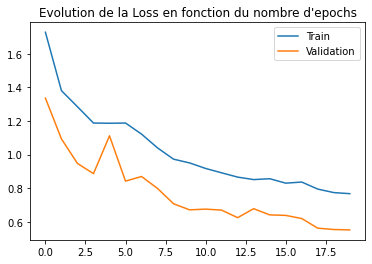

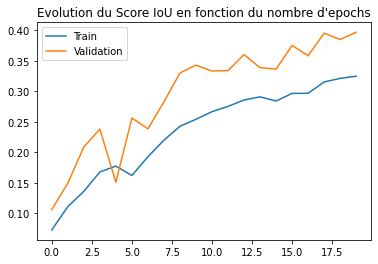

In [76]:
plot_results(metrics_3)

In [77]:
print('Nombre de paramètres du réseau : ', metrics_3['Nombre de paramètres'][0])

Nombre de paramètres du réseau :  2883528


#### Temps de calcul = 3h 16mns

#### Conclusion :
- Ce modèle est nettement moins bon que le précédent
- Le score IoU sur le jeu de validation a diminué de façon importante à 0.5
- On peut en conclure qu'une transformation modérée des images est bénéfique pour l'apprentissage mais qu'une transformation top conséquente est dévaforable pour l'apprentissage
- Cela peut s'expliquer par le fait que la première version modérée effectue une transformation de l'image mais tout en gardant sa structure, alors que la seconde version 'destructure' l'image comme nous l'avons vu sur l'exemple ci-dessus
- **Nous retenons donc la première version de l'augmentation pour les prochains modèles**
> **Le meilleur modèle à ce stade est le modèle simple avec augmentation première version**

### 4 - Modèle : Architecture Unet - Fonction de perte CategoricalCrossEntropy - Avec augmentation des données
- L'architecture de ce modèle est plus avancée : il s'agit d'un réseau de type Unet

#### Création de l'expérimentation

In [78]:
experiment_name = '4_cityscape_fs_unet_aug'

In [79]:
experiment = Experiment(workspace=ws, name=experiment_name)

#### Lancement du script

In [80]:
src = ScriptRunConfig(source_directory=project_folder, 
                      script='4_train_fs_unet_aug.py',
                      arguments=script_arguments,
                      compute_target=compute, 
                      environment=environment)

In [81]:
run_4 = experiment.submit(config=src)

In [82]:
run_4

Experiment,Id,Type,Status,Details Page,Docs Page
4_cityscape_fs_unet_aug,4_cityscape_fs_unet_aug_1633376852_615908ac,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [83]:
%%time
run_4.wait_for_completion(show_output=True)

RunId: 4_cityscape_fs_unet_aug_1633376852_615908ac
Web View: https://ml.azure.com/runs/4_cityscape_fs_unet_aug_1633376852_615908ac?wsid=/subscriptions/dc0050bb-8e50-4b60-8aac-034371ba1a2a/resourcegroups/OC-IA-P8-GPU/workspaces/WS-IA-P8-GPU&tid=894ad120-c276-4dfa-b218-d82b3fece6a7

Streaming azureml-logs/55_azureml-execution-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

2021-10-04T19:47:57Z Running following command: /bin/bash -c sudo blobfuse /mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/4_cityscape_fs_unet_aug_1633376852_615908ac/mounts/workspaceblobstore --tmp-path=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/4_cityscape_fs_unet_aug_1633376852_615908ac/caches/workspaceblobstore -o ro --file-cache-timeout-in-seconds=1000000 --cache-size-mb=260242 -o nonempty -o allow_other --config-file=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/4_cityscape_fs_unet_aug_1633376852_615908ac/configs/workspaceblobstore.cfg --log-level

2021-10-04 19:48:36.068320: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-10-04 19:48:36.753423: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10

 2/74 [..............................] - ETA: 56s - loss: 2.1567 - iou_score: 0.0980WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.5236s vs `on_train_batch_end` time: 1.0577s). Check your callbacks.

74/74 [==============================] - ETA: 0s - loss: 0.8777 - iou_score: 0.3047
Epoch 00001: val_loss improved from inf to 4.68647, saving model to cityscape-fs-unet-aug.h5

74/74 [==============================] - 569s 8s/step - loss: 0.8777 - iou_score: 0.3047 - val_loss: 4.6865 - val_iou_score: 0.1020
Epoch 2/20

17/74 [=====>........................] - ETA: 5:04 - loss: 0.6287 - iou_score: 0.3912


74/74 [==============================] - ETA: 0s - loss: 0.6235 - iou_score: 0.3942
Epoch 00002: val_loss improved from 4.68647 to 3.28677, saving model to cityscape-fs-unet-aug.h5

74/74 [==============================] - 561s 8s/step - loss: 0.6235 - iou_score: 0.3942 - val_loss: 3.2868 - val_iou_score: 0.1527
Epoch 3/20

37/74 [==============>...............] - ETA: 3:51 - loss: 0.5903 - iou_score: 0.4155


74/74 [==============================] - ETA: 0s - loss: 0.5709 - iou_score: 0.4229
Epoch 00003: val_loss improved from 3.28677 to 1.36269, saving model to cityscape-fs-unet-aug.h5

74/74 [==============================] - 563s 8s/step - loss: 0.5709 - iou_score: 0.4229 - val_loss: 1.3627 - val_iou_score: 0.2112
Epoch 4/20

58/74 [======================>.......] - ETA: 1:37 - loss: 0.5452 - iou_score: 0.4390


74/74 [==============================] - ETA: 0s - loss: 0.5453 - iou_score: 0.4382
Epoch 00004: val_loss improved from 1.36269 to 1.18216, saving model to cityscape-fs-unet-aug.h5

74/74 [==============================] - 549s 7s/step - loss: 0.5453 - iou_score: 0.4382 - val_loss: 1.1822 - val_iou_score: 0.2535
Epoch 5/20

74/74 [==============================] - ETA: 0s - loss: 0.5174 - iou_score: 0.4566
Epoch 00005: val_loss improved from 1.18216 to 1.08856, saving model to cityscape-fs-unet-aug.h5

74/74 [==============================] - 554s 7s/step - loss: 0.5174 - iou_score: 0.4566 - val_loss: 1.0886 - val_iou_score: 0.2713
Epoch 6/20

 2/74 [..............................] - ETA: 3:48 - loss: 0.4417 - iou_score: 0.4762


74/74 [==============================] - ETA: 0s - loss: 0.4858 - iou_score: 0.4752
Epoch 00006: val_loss improved from 1.08856 to 0.76632, saving model to cityscape-fs-unet-aug.h5

74/74 [==============================] - 556s 8s/step - loss: 0.4858 - iou_score: 0.4752 - val_loss: 0.7663 - val_iou_score: 0.3362
Epoch 7/20

33/74 [============>.................] - ETA: 4:15 - loss: 0.4590 - iou_score: 0.4912


74/74 [==============================] - ETA: 0s - loss: 0.4701 - iou_score: 0.4854
Epoch 00007: val_loss improved from 0.76632 to 0.60732, saving model to cityscape-fs-unet-aug.h5

74/74 [==============================] - 556s 8s/step - loss: 0.4701 - iou_score: 0.4854 - val_loss: 0.6073 - val_iou_score: 0.4633
Epoch 8/20

57/74 [======================>.......] - ETA: 1:43 - loss: 0.4620 - iou_score: 0.4924


74/74 [==============================] - ETA: 0s - loss: 0.4540 - iou_score: 0.4966
Epoch 00008: val_loss improved from 0.60732 to 0.48514, saving model to cityscape-fs-unet-aug.h5

74/74 [==============================] - 555s 8s/step - loss: 0.4540 - iou_score: 0.4966 - val_loss: 0.4851 - val_iou_score: 0.4720
Epoch 9/20

74/74 [==============================] - ETA: 0s - loss: 0.4311 - iou_score: 0.5126
Epoch 00009: val_loss did not improve from 0.48514

74/74 [==============================] - 558s 8s/step - loss: 0.4311 - iou_score: 0.5126 - val_loss: 0.5045 - val_iou_score: 0.4947
Epoch 10/20

10/74 [===>..........................] - ETA: 5:33 - loss: 0.3967 - iou_score: 0.5297


74/74 [==============================] - ETA: 0s - loss: 0.4176 - iou_score: 0.5225
Epoch 00010: val_loss improved from 0.48514 to 0.38979, saving model to cityscape-fs-unet-aug.h5

74/74 [==============================] - 572s 8s/step - loss: 0.4176 - iou_score: 0.5225 - val_loss: 0.3898 - val_iou_score: 0.5355
Epoch 11/20

35/74 [=============>................] - ETA: 4:05 - loss: 0.4069 - iou_score: 0.5279


74/74 [==============================] - ETA: 0s - loss: 0.4071 - iou_score: 0.5268
Epoch 00011: val_loss did not improve from 0.38979

74/74 [==============================] - 588s 8s/step - loss: 0.4071 - iou_score: 0.5268 - val_loss: 0.4172 - val_iou_score: 0.5266
Epoch 12/20

59/74 [======================>.......] - ETA: 1:36 - loss: 0.3971 - iou_score: 0.5351


74/74 [==============================] - ETA: 0s - loss: 0.3925 - iou_score: 0.5383
Epoch 00012: val_loss did not improve from 0.38979

74/74 [==============================] - 582s 8s/step - loss: 0.3925 - iou_score: 0.5383 - val_loss: 0.3950 - val_iou_score: 0.5391
Epoch 13/20

74/74 [==============================] - ETA: 0s - loss: 0.3842 - iou_score: 0.5429
Epoch 00013: val_loss improved from 0.38979 to 0.33688, saving model to cityscape-fs-unet-aug.h5

74/74 [==============================] - 585s 8s/step - loss: 0.3842 - iou_score: 0.5429 - val_loss: 0.3369 - val_iou_score: 0.5759
Epoch 14/20

 6/74 [=>............................] - ETA: 5:05 - loss: 0.4094 - iou_score: 0.5546


74/74 [==============================] - ETA: 0s - loss: 0.3684 - iou_score: 0.5560
Epoch 00014: val_loss did not improve from 0.33688

74/74 [==============================] - 586s 8s/step - loss: 0.3684 - iou_score: 0.5560 - val_loss: 0.3505 - val_iou_score: 0.5578
Epoch 15/20

31/74 [===========>..................] - ETA: 4:23 - loss: 0.3555 - iou_score: 0.5640


74/74 [==============================] - ETA: 0s - loss: 0.3566 - iou_score: 0.5653
Epoch 00015: val_loss did not improve from 0.33688

74/74 [==============================] - 573s 8s/step - loss: 0.3566 - iou_score: 0.5653 - val_loss: 0.4270 - val_iou_score: 0.5093
Epoch 16/20

61/74 [=======================>......] - ETA: 1:23 - loss: 0.3582 - iou_score: 0.5644


74/74 [==============================] - ETA: 0s - loss: 0.3572 - iou_score: 0.5644
Epoch 00016: val_loss did not improve from 0.33688

74/74 [==============================] - 572s 8s/step - loss: 0.3572 - iou_score: 0.5644 - val_loss: 0.3456 - val_iou_score: 0.5617
Epoch 17/20

74/74 [==============================] - ETA: 0s - loss: 0.3427 - iou_score: 0.5751
Epoch 00017: val_loss did not improve from 0.33688

74/74 [==============================] - 574s 8s/step - loss: 0.3427 - iou_score: 0.5751 - val_loss: 0.3402 - val_iou_score: 0.5854
Epoch 18/20

 9/74 [==>...........................] - ETA: 5:15 - loss: 0.3116 - iou_score: 0.5967


74/74 [==============================] - ETA: 0s - loss: 0.3383 - iou_score: 0.5802
Epoch 00018: val_loss improved from 0.33688 to 0.31306, saving model to cityscape-fs-unet-aug.h5

74/74 [==============================] - 563s 8s/step - loss: 0.3383 - iou_score: 0.5802 - val_loss: 0.3131 - val_iou_score: 0.5964
Epoch 19/20

38/74 [==============>...............] - ETA: 3:38 - loss: 0.3388 - iou_score: 0.5793


74/74 [==============================] - ETA: 0s - loss: 0.3324 - iou_score: 0.5834
Epoch 00019: val_loss did not improve from 0.31306

74/74 [==============================] - 561s 8s/step - loss: 0.3324 - iou_score: 0.5834 - val_loss: 0.3229 - val_iou_score: 0.5981
Epoch 20/20

60/74 [=======================>......] - ETA: 1:26 - loss: 0.3220 - iou_score: 0.5912


74/74 [==============================] - ETA: 0s - loss: 0.3227 - iou_score: 0.5902
Epoch 00020: val_loss did not improve from 0.31306

74/74 [==============================] - 550s 7s/step - loss: 0.3227 - iou_score: 0.5902 - val_loss: 0.3323 - val_iou_score: 0.5935


[2021-10-04T22:59:35.733624] The experiment completed successfully. Finalizing run...
Cleaning up all outstanding Run operations, waiting 900.0 seconds
3 items cleaning up...
Cleanup took 0.17500638961791992 seconds
[2021-10-04T22:59:41.357761] Finished context manager injector.
2021/10/04 22:59:42 Attempt 1 of http call to http://10.0.0.4:16384/sendlogstoartifacts/status
2021/10/04 22:59:42 Send process info logs to master server succeeded
2021/10/04 22:59:42 Not exporting to RunHistory as the exporter is either stopped or there is no data.
Stopped: false
OriginalData: 2
FilteredData: 0.
2021/10/04 22:59:42 Process Exiting with Code:  0

Streaming azureml-logs/75_job_post-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957

{'runId': '4_cityscape_fs_unet_aug_1633376852_615908ac',
 'target': 'obonheur1',
 'status': 'Completed',
 'startTimeUtc': '2021-10-04T19:47:56.771165Z',
 'endTimeUtc': '2021-10-04T22:59:55.378832Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'f8ba4d08-d08d-4d49-ab9c-800ade6ab97e',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '04ea4a17-f1ee-4144-a1b2-d352f7bf27f6'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__04ea4a17', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': '4_train_fs_unet_aug.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-path', 'DatasetConsumptionConfig:input__04ea4a17'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'obonheur1',
  'dataReferences': {},
  'data': {'input__04ea4a17': {'

#### Résultats

In [84]:
metrics_4 = run_4.get_metrics()

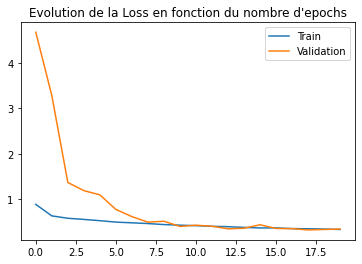

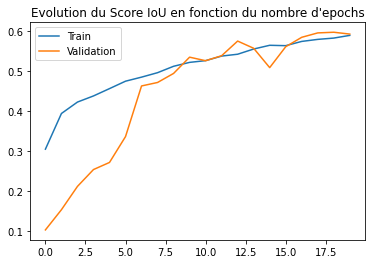

In [85]:
plot_results(metrics_4)

In [86]:
print('Nombre de paramètres du réseau : ', metrics_4['Nombre de paramètres'][0])

Nombre de paramètres du réseau :  31059592


#### Temps de calcul = 3h 11mns

#### Conclusion :
- Ce modèle est nettement meilleur que le précédent
- Le score IoU sur le jeu de validation a augmenté à 0.59
- Le temps d'exécution est légèrement inférieur
- Il y a plus de paramètre, ce qui est très logique car le réseau est plus complexe
- Il n'y a pas d'overfitting
> **C'est le meilleur modèle à ce stade**

## Modélisation avec la librairie 'segmentation-models'

### 5 - Modèle : Architecture Unet - Fonction de perte CategoricalCrossEntropy - Avec augmentation des données - Backbone VGGNet
- Ce modèle est une architecture Unet implémentée avec la librairie segmentation-model
- Les poids sont initialisés aléatoirement

#### Création de l'expérimentation

In [87]:
experiment_name = '5_cityscape_sm_unet_aug_vgg'

In [88]:
experiment = Experiment(workspace=ws, name=experiment_name)

#### Lancement du script

In [89]:
src = ScriptRunConfig(source_directory=project_folder, 
                      script='5_train_sm_unet_aug_vgg.py',
                      arguments=script_arguments,
                      compute_target=compute, 
                      environment=environment)

In [90]:
run_5 = experiment.submit(config=src)

In [91]:
run_5

Experiment,Id,Type,Status,Details Page,Docs Page
5_cityscape_sm_unet_aug_vgg,5_cityscape_sm_unet_aug_vgg_1633416416_8a9997fe,azureml.scriptrun,Queued,Link to Azure Machine Learning studio,Link to Documentation


In [92]:
%%time
# Shows output of the run on stdout.
run_5.wait_for_completion(show_output=True)

RunId: 5_cityscape_sm_unet_aug_vgg_1633416416_8a9997fe
Web View: https://ml.azure.com/runs/5_cityscape_sm_unet_aug_vgg_1633416416_8a9997fe?wsid=/subscriptions/dc0050bb-8e50-4b60-8aac-034371ba1a2a/resourcegroups/OC-IA-P8-GPU/workspaces/WS-IA-P8-GPU&tid=894ad120-c276-4dfa-b218-d82b3fece6a7

Streaming azureml-logs/55_azureml-execution-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

2021-10-05T06:47:35Z Running following command: /bin/bash -c sudo blobfuse /mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/5_cityscape_sm_unet_aug_vgg_1633416416_8a9997fe/mounts/workspaceblobstore --tmp-path=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/5_cityscape_sm_unet_aug_vgg_1633416416_8a9997fe/caches/workspaceblobstore -o ro --file-cache-timeout-in-seconds=1000000 --cache-size-mb=260246 -o nonempty -o allow_other --config-file=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/5_cityscape_sm_unet_aug_vgg_1633416416_8a9997fe/configs/workspaceblobs


Streaming azureml-logs/70_driver_log.txt

bash: /azureml-envs/azureml_1e5a6148f062de911cc865d14d4aee17/lib/libtinfo.so.5: no version information available (required by bash)
2021/10/05 06:48:18 Starting App Insight Logger for task:  runTaskLet
2021/10/05 06:48:18 Version: 3.0.01732.0009 Branch: 2021-09-24 Commit: 10bd51d
2021/10/05 06:48:18 Attempt 1 of http call to http://10.0.0.4:16384/sendlogstoartifacts/info
bash: /azureml-envs/azureml_1e5a6148f062de911cc865d14d4aee17/lib/libtinfo.so.5: no version information available (required by bash)
2021/10/05 06:48:18 Send process info logs to master server succeeded
2021/10/05 06:48:18 Attempt 1 of http call to http://10.0.0.4:16384/sendlogstoartifacts/status
2021/10/05 06:48:18 Send process info logs to master server succeeded
[2021-10-05T06:48:19.347786] Entering context manager injector.
[2021-10-05T06:48:22.679426] context_manager_injector.py Command line Options: Namespace(inject=['ProjectPythonPath:context_managers.ProjectPythonPath',

74/74 [==============================] - ETA: 0s - loss: 1.2801 - iou_score: 0.1700
Epoch 00001: val_loss improved from inf to 2.37132, saving model to cityscape-sm-unet-aug-vgg.h5

74/74 [==============================] - 524s 7s/step - loss: 1.2801 - iou_score: 0.1700 - val_loss: 2.3713 - val_iou_score: 0.1028
Epoch 2/20

37/74 [==============>...............] - ETA: 3:17 - loss: 0.8517 - iou_score: 0.2913


74/74 [==============================] - ETA: 0s - loss: 0.7749 - iou_score: 0.3181
Epoch 00002: val_loss improved from 2.37132 to 1.73477, saving model to cityscape-sm-unet-aug-vgg.h5

74/74 [==============================] - 520s 7s/step - loss: 0.7749 - iou_score: 0.3181 - val_loss: 1.7348 - val_iou_score: 0.1510
Epoch 3/20

64/74 [========================>.....] - ETA: 56s - loss: 0.6635 - iou_score: 0.3682 


74/74 [==============================] - ETA: 0s - loss: 0.6537 - iou_score: 0.3723
Epoch 00003: val_loss did not improve from 1.73477

74/74 [==============================] - 525s 7s/step - loss: 0.6537 - iou_score: 0.3723 - val_loss: 1.8215 - val_iou_score: 0.1545
Epoch 4/20

74/74 [==============================] - ETA: 0s - loss: 0.5994 - iou_score: 0.4030
Epoch 00004: val_loss improved from 1.73477 to 1.12789, saving model to cityscape-sm-unet-aug-vgg.h5

74/74 [==============================] - 543s 7s/step - loss: 0.5994 - iou_score: 0.4030 - val_loss: 1.1279 - val_iou_score: 0.2198
Epoch 5/20

10/74 [===>..........................] - ETA: 5:05 - loss: 0.6101 - iou_score: 0.3973


74/74 [==============================] - ETA: 0s - loss: 0.5701 - iou_score: 0.4193
Epoch 00005: val_loss improved from 1.12789 to 0.72120, saving model to cityscape-sm-unet-aug-vgg.h5

74/74 [==============================] - 536s 7s/step - loss: 0.5701 - iou_score: 0.4193 - val_loss: 0.7212 - val_iou_score: 0.3031
Epoch 6/20

37/74 [==============>...............] - ETA: 3:31 - loss: 0.5435 - iou_score: 0.4301


74/74 [==============================] - ETA: 0s - loss: 0.5447 - iou_score: 0.4341
Epoch 00006: val_loss did not improve from 0.72120

74/74 [==============================] - 531s 7s/step - loss: 0.5447 - iou_score: 0.4341 - val_loss: 0.7479 - val_iou_score: 0.2976
Epoch 7/20

62/74 [========================>.....] - ETA: 1:08 - loss: 0.5239 - iou_score: 0.4454


74/74 [==============================] - ETA: 0s - loss: 0.5280 - iou_score: 0.4446
Epoch 00007: val_loss did not improve from 0.72120

74/74 [==============================] - 529s 7s/step - loss: 0.5280 - iou_score: 0.4446 - val_loss: 0.8350 - val_iou_score: 0.2763
Epoch 8/20

74/74 [==============================] - ETA: 0s - loss: 0.5122 - iou_score: 0.4530
Epoch 00008: val_loss improved from 0.72120 to 0.65501, saving model to cityscape-sm-unet-aug-vgg.h5

74/74 [==============================] - 539s 7s/step - loss: 0.5122 - iou_score: 0.4530 - val_loss: 0.6550 - val_iou_score: 0.3741
Epoch 9/20

 6/74 [=>............................] - ETA: 5:12 - loss: 0.5274 - iou_score: 0.4523


74/74 [==============================] - ETA: 0s - loss: 0.5074 - iou_score: 0.4616
Epoch 00009: val_loss improved from 0.65501 to 0.51841, saving model to cityscape-sm-unet-aug-vgg.h5

74/74 [==============================] - 547s 7s/step - loss: 0.5074 - iou_score: 0.4616 - val_loss: 0.5184 - val_iou_score: 0.4305
Epoch 10/20

33/74 [============>.................] - ETA: 3:46 - loss: 0.4987 - iou_score: 0.4669


74/74 [==============================] - ETA: 0s - loss: 0.4787 - iou_score: 0.4753
Epoch 00010: val_loss improved from 0.51841 to 0.45482, saving model to cityscape-sm-unet-aug-vgg.h5

74/74 [==============================] - 536s 7s/step - loss: 0.4787 - iou_score: 0.4753 - val_loss: 0.4548 - val_iou_score: 0.4671
Epoch 11/20

54/74 [====================>.........] - ETA: 1:57 - loss: 0.4744 - iou_score: 0.4844


74/74 [==============================] - ETA: 0s - loss: 0.4672 - iou_score: 0.4878
Epoch 00011: val_loss did not improve from 0.45482

74/74 [==============================] - 539s 7s/step - loss: 0.4672 - iou_score: 0.4878 - val_loss: 0.5223 - val_iou_score: 0.4314
Epoch 12/20

74/74 [==============================] - ETA: 0s - loss: 0.4613 - iou_score: 0.4899
Epoch 00012: val_loss improved from 0.45482 to 0.40216, saving model to cityscape-sm-unet-aug-vgg.h5

74/74 [==============================] - 524s 7s/step - loss: 0.4613 - iou_score: 0.4899 - val_loss: 0.4022 - val_iou_score: 0.5080
Epoch 13/20

 3/74 [>.............................] - ETA: 4:32 - loss: 0.4504 - iou_score: 0.5108


74/74 [==============================] - ETA: 0s - loss: 0.4385 - iou_score: 0.5037
Epoch 00013: val_loss did not improve from 0.40216

74/74 [==============================] - 503s 7s/step - loss: 0.4385 - iou_score: 0.5037 - val_loss: 0.4452 - val_iou_score: 0.4789
Epoch 14/20

24/74 [========>.....................] - ETA: 4:28 - loss: 0.4373 - iou_score: 0.5027


74/74 [==============================] - ETA: 0s - loss: 0.4402 - iou_score: 0.5052
Epoch 00014: val_loss did not improve from 0.40216

74/74 [==============================] - 519s 7s/step - loss: 0.4402 - iou_score: 0.5052 - val_loss: 0.4374 - val_iou_score: 0.5058
Epoch 15/20

53/74 [====================>.........] - ETA: 1:57 - loss: 0.4448 - iou_score: 0.5012


74/74 [==============================] - ETA: 0s - loss: 0.4357 - iou_score: 0.5079
Epoch 00015: val_loss improved from 0.40216 to 0.38205, saving model to cityscape-sm-unet-aug-vgg.h5

74/74 [==============================] - 519s 7s/step - loss: 0.4357 - iou_score: 0.5079 - val_loss: 0.3821 - val_iou_score: 0.5193
Epoch 16/20

74/74 [==============================] - ETA: 0s - loss: 0.4189 - iou_score: 0.5189


Epoch 00016: val_loss did not improve from 0.38205

74/74 [==============================] - 539s 7s/step - loss: 0.4189 - iou_score: 0.5189 - val_loss: 0.4250 - val_iou_score: 0.5066
Epoch 17/20

74/74 [==============================] - ETA: 0s - loss: 0.4201 - iou_score: 0.5191
Epoch 00017: val_loss did not improve from 0.38205

74/74 [==============================] - 550s 7s/step - loss: 0.4201 - iou_score: 0.5191 - val_loss: 0.4081 - val_iou_score: 0.5109
Epoch 18/20

21/74 [=======>......................] - ETA: 5:22 - loss: 0.4044 - iou_score: 0.5286


74/74 [==============================] - ETA: 0s - loss: 0.4110 - iou_score: 0.5262
Epoch 00018: val_loss improved from 0.38205 to 0.36541, saving model to cityscape-sm-unet-aug-vgg.h5

74/74 [==============================] - 570s 8s/step - loss: 0.4110 - iou_score: 0.5262 - val_loss: 0.3654 - val_iou_score: 0.5488
Epoch 19/20

43/74 [================>.............] - ETA: 3:04 - loss: 0.3882 - iou_score: 0.5374


74/74 [==============================] - ETA: 0s - loss: 0.3955 - iou_score: 0.5348
Epoch 00019: val_loss improved from 0.36541 to 0.36315, saving model to cityscape-sm-unet-aug-vgg.h5

74/74 [==============================] - 547s 7s/step - loss: 0.3955 - iou_score: 0.5348 - val_loss: 0.3632 - val_iou_score: 0.5516
Epoch 20/20

66/74 [=========================>....] - ETA: 48s - loss: 0.4003 - iou_score: 0.5331


74/74 [==============================] - ETA: 0s - loss: 0.3964 - iou_score: 0.5345

Streaming azureml-logs/75_job_post-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

[2021-10-05T09:49:44.442897] Entering job release
[2021-10-05T09:49:45.222186] Starting job release
[2021-10-05T09:49:45.222577] Logging experiment finalizing status in history service.
[2021-10-05T09:49:45.223295] job release stage : upload_datastore starting...Starting the daemon thread to refresh tokens in background for process with pid = 1389

[2021-10-05T09:49:45.223566] job release stage : start importing azureml.history._tracking in run_history_release.
[2021-10-05T09:49:45.225649] job release stage : execute_job_release starting...[2021-10-05T09:49:45.225820] job release stage : copy_batchai_cached_logs starting...

[2021-10-05T09:49:45.225933] job release stage : copy_batchai_cached_logs completed...
[2021-10-05T09:49:45.236798] Entering context manager injector.
[2021-10-05T09:49:

{'runId': '5_cityscape_sm_unet_aug_vgg_1633416416_8a9997fe',
 'target': 'obonheur1',
 'status': 'Completed',
 'startTimeUtc': '2021-10-05T06:47:34.315679Z',
 'endTimeUtc': '2021-10-05T09:49:58.553626Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'f8ba4d08-d08d-4d49-ab9c-800ade6ab97e',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '04ea4a17-f1ee-4144-a1b2-d352f7bf27f6'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__04ea4a17', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': '5_train_sm_unet_aug_vgg.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-path', 'DatasetConsumptionConfig:input__04ea4a17'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'obonheur1',
  'dataReferences': {},
  'data': {'input__04ea4

#### Résultats

In [93]:
metrics_5 = run_5.get_metrics()

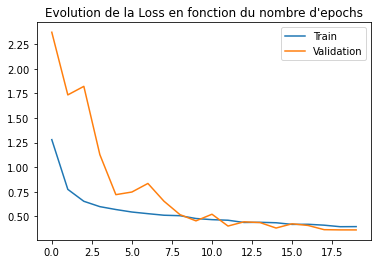

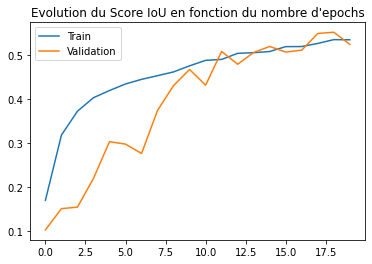

In [94]:
plot_results(metrics_5)

In [95]:
print('Nombre de paramètres du réseau : ', metrics_5['Nombre de paramètres'][0])

Nombre de paramètres du réseau :  23753288


#### Temps de calcul = 3h 02mns

#### Conclusion :
- Ce modèle est globalement en ligne avec le précédent
- Le score IoU sur le jeu de validation est un peu inférieur, mais le temps de calcul est également inférieur et il y a moins de paramètre
- Il n'y a pas d'overfitting

### 6 - Modèle : Architecture Unet - Fonction de perte CategoricalCrossEntropy -  Avec augmentation des données - Backbone VGGNet - Poids Imagenet
- Ce modèle reprend le précédent mais cette fois-ci les poids sont initialisés avec un pré entraînement sur le jeu de données Imagenet (application de Transfer Learning)

#### Création de l'expérimentation

In [96]:
experiment_name = '6_cityscape_sm_unet_aug_vgg_imagenet'

In [97]:
experiment = Experiment(workspace=ws, name=experiment_name)

#### Lancement du script

In [98]:
src = ScriptRunConfig(source_directory=project_folder, 
                      script='6_train_sm_unet_aug_vgg_imagenet.py',
                      arguments=script_arguments,
                      compute_target=compute, 
                      environment=environment)

In [99]:
run_6 = experiment.submit(config=src)

In [100]:
run_6

Experiment,Id,Type,Status,Details Page,Docs Page
6_cityscape_sm_unet_aug_vgg_imagenet,6_cityscape_sm_unet_aug_vgg_imagenet_1633427759_c27caa57,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [101]:
%%time
# Shows output of the run on stdout.
run_6.wait_for_completion(show_output=True)

RunId: 6_cityscape_sm_unet_aug_vgg_imagenet_1633427759_c27caa57
Web View: https://ml.azure.com/runs/6_cityscape_sm_unet_aug_vgg_imagenet_1633427759_c27caa57?wsid=/subscriptions/dc0050bb-8e50-4b60-8aac-034371ba1a2a/resourcegroups/OC-IA-P8-GPU/workspaces/WS-IA-P8-GPU&tid=894ad120-c276-4dfa-b218-d82b3fece6a7

Streaming azureml-logs/70_driver_log.txt

bash: /azureml-envs/azureml_1e5a6148f062de911cc865d14d4aee17/lib/libtinfo.so.5: no version information available (required by bash)
2021/10/05 09:56:39 Starting App Insight Logger for task:  runTaskLet
2021/10/05 09:56:39 Version: 3.0.01732.0009 Branch: 2021-09-24 Commit: 10bd51d
2021/10/05 09:56:39 Attempt 1 of http call to http://10.0.0.4:16384/sendlogstoartifacts/info
bash: /azureml-envs/azureml_1e5a6148f062de911cc865d14d4aee17/lib/libtinfo.so.5: no version information available (required by bash)
2021/10/05 09:56:39 Send process info logs to master server succeeded
2021/10/05 09:56:39 Attempt 1 of http call to http://10.0.0.4:16384/sendlo

Epoch 1/20
2021-10-05 09:57:01.149420: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-10-05 09:57:01.859105: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10

 2/74 [..............................] - ETA: 28s - loss: 2.1811 - iou_score: 0.0564WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2769s vs `on_train_batch_end` time: 0.5195s). Check your callbacks.

74/74 [==============================] - ETA: 0s - loss: 1.0744 - iou_score: 0.2286
Epoch 00001: val_loss improved from inf to 1.13157, saving model to cityscape-sm-unet-aug-vgg-imagenet.h5

74/74 [==============================] - 543s 7s/step - loss: 1.0744 - iou_score: 0.2286 - val_loss: 1.1316 - val_iou_score: 0.2367
Epoch 2/20

17/74 [=====>........................] - ETA: 4:52 - loss: 0.7542 - iou_score: 0.3265


74/74 [==============================] - ETA: 0s - loss: 0.6786 - iou_score: 0.3649
Epoch 00002: val_loss did not improve from 1.13157

74/74 [==============================] - 546s 7s/step - loss: 0.6786 - iou_score: 0.3649 - val_loss: 1.2873 - val_iou_score: 0.2487
Epoch 3/20

45/74 [=================>............] - ETA: 2:47 - loss: 0.5860 - iou_score: 0.4115


74/74 [==============================] - ETA: 0s - loss: 0.5845 - iou_score: 0.4126
Epoch 00003: val_loss did not improve from 1.13157

74/74 [==============================] - 529s 7s/step - loss: 0.5845 - iou_score: 0.4126 - val_loss: 1.5190 - val_iou_score: 0.2048
Epoch 4/20

69/74 [==========================>...] - ETA: 28s - loss: 0.5421 - iou_score: 0.4397


74/74 [==============================] - ETA: 0s - loss: 0.5387 - iou_score: 0.4405
Epoch 00004: val_loss improved from 1.13157 to 0.72109, saving model to cityscape-sm-unet-aug-vgg-imagenet.h5

74/74 [==============================] - 527s 7s/step - loss: 0.5387 - iou_score: 0.4405 - val_loss: 0.7211 - val_iou_score: 0.3595
Epoch 5/20

74/74 [==============================] - ETA: 0s - loss: 0.5139 - iou_score: 0.4537
Epoch 00005: val_loss did not improve from 0.72109

74/74 [==============================] - 534s 7s/step - loss: 0.5139 - iou_score: 0.4537 - val_loss: 0.7293 - val_iou_score: 0.3524
Epoch 6/20

23/74 [========>.....................] - ETA: 4:35 - loss: 0.4711 - iou_score: 0.4679


74/74 [==============================] - ETA: 0s - loss: 0.4836 - iou_score: 0.4737
Epoch 00006: val_loss improved from 0.72109 to 0.70352, saving model to cityscape-sm-unet-aug-vgg-imagenet.h5

74/74 [==============================] - 532s 7s/step - loss: 0.4836 - iou_score: 0.4737 - val_loss: 0.7035 - val_iou_score: 0.3430
Epoch 7/20

46/74 [=================>............] - ETA: 2:37 - loss: 0.4662 - iou_score: 0.4832


74/74 [==============================] - ETA: 0s - loss: 0.4602 - iou_score: 0.4875
Epoch 00007: val_loss improved from 0.70352 to 0.61336, saving model to cityscape-sm-unet-aug-vgg-imagenet.h5

74/74 [==============================] - 527s 7s/step - loss: 0.4602 - iou_score: 0.4875 - val_loss: 0.6134 - val_iou_score: 0.3918
Epoch 8/20

66/74 [=========================>....] - ETA: 47s - loss: 0.4393 - iou_score: 0.4989


74/74 [==============================] - ETA: 0s - loss: 0.4396 - iou_score: 0.4990
Epoch 00008: val_loss improved from 0.61336 to 0.43230, saving model to cityscape-sm-unet-aug-vgg-imagenet.h5

74/74 [==============================] - 551s 7s/step - loss: 0.4396 - iou_score: 0.4990 - val_loss: 0.4323 - val_iou_score: 0.4644
Epoch 9/20

74/74 [==============================] - ETA: 0s - loss: 0.4335 - iou_score: 0.5037
Epoch 00009: val_loss did not improve from 0.43230

74/74 [==============================] - 542s 7s/step - loss: 0.4335 - iou_score: 0.5037 - val_loss: 0.4330 - val_iou_score: 0.4835
Epoch 10/20

16/74 [=====>........................] - ETA: 5:42 - loss: 0.4259 - iou_score: 0.5130


74/74 [==============================] - ETA: 0s - loss: 0.4159 - iou_score: 0.5162
Epoch 00010: val_loss improved from 0.43230 to 0.38080, saving model to cityscape-sm-unet-aug-vgg-imagenet.h5

74/74 [==============================] - 557s 8s/step - loss: 0.4159 - iou_score: 0.5162 - val_loss: 0.3808 - val_iou_score: 0.5152
Epoch 11/20

36/74 [=============>................] - ETA: 3:35 - loss: 0.4028 - iou_score: 0.5230


74/74 [==============================] - ETA: 0s - loss: 0.4088 - iou_score: 0.5219
Epoch 00011: val_loss improved from 0.38080 to 0.36787, saving model to cityscape-sm-unet-aug-vgg-imagenet.h5

74/74 [==============================] - 539s 7s/step - loss: 0.4088 - iou_score: 0.5219 - val_loss: 0.3679 - val_iou_score: 0.5208
Epoch 12/20

63/74 [========================>.....] - ETA: 1:06 - loss: 0.4007 - iou_score: 0.5298


74/74 [==============================] - ETA: 0s - loss: 0.4003 - iou_score: 0.5291
Epoch 00012: val_loss did not improve from 0.36787

74/74 [==============================] - 554s 7s/step - loss: 0.4003 - iou_score: 0.5291 - val_loss: 0.5351 - val_iou_score: 0.4710
Epoch 13/20

74/74 [==============================] - ETA: 0s - loss: 0.3974 - iou_score: 0.5309
Epoch 00013: val_loss did not improve from 0.36787

74/74 [==============================] - 549s 7s/step - loss: 0.3974 - iou_score: 0.5309 - val_loss: 0.3934 - val_iou_score: 0.5285
Epoch 14/20

11/74 [===>..........................] - ETA: 5:37 - loss: 0.3869 - iou_score: 0.5382


74/74 [==============================] - ETA: 0s - loss: 0.3861 - iou_score: 0.5415
Epoch 00014: val_loss did not improve from 0.36787

74/74 [==============================] - 549s 7s/step - loss: 0.3861 - iou_score: 0.5415 - val_loss: 0.3705 - val_iou_score: 0.5362
Epoch 15/20

41/74 [===============>..............] - ETA: 3:14 - loss: 0.3810 - iou_score: 0.5462


74/74 [==============================] - ETA: 0s - loss: 0.3801 - iou_score: 0.5445
Epoch 00015: val_loss improved from 0.36787 to 0.36693, saving model to cityscape-sm-unet-aug-vgg-imagenet.h5

74/74 [==============================] - 553s 7s/step - loss: 0.3801 - iou_score: 0.5445 - val_loss: 0.3669 - val_iou_score: 0.5485
Epoch 16/20

61/74 [=======================>......] - ETA: 1:15 - loss: 0.3780 - iou_score: 0.5483


74/74 [==============================] - ETA: 0s - loss: 0.3729 - iou_score: 0.5507
Epoch 00016: val_loss improved from 0.36693 to 0.33655, saving model to cityscape-sm-unet-aug-vgg-imagenet.h5

74/74 [==============================] - 534s 7s/step - loss: 0.3729 - iou_score: 0.5507 - val_loss: 0.3366 - val_iou_score: 0.5599
Epoch 17/20

74/74 [==============================] - ETA: 0s - loss: 0.3541 - iou_score: 0.5638
Epoch 00017: val_loss improved from 0.33655 to 0.33580, saving model to cityscape-sm-unet-aug-vgg-imagenet.h5

74/74 [==============================] - 523s 7s/step - loss: 0.3541 - iou_score: 0.5638 - val_loss: 0.3358 - val_iou_score: 0.5717
Epoch 18/20

 5/74 [=>............................] - ETA: 4:55 - loss: 0.3355 - iou_score: 0.5703


74/74 [==============================] - ETA: 0s - loss: 0.3461 - iou_score: 0.5716
Epoch 00018: val_loss did not improve from 0.33580

74/74 [==============================] - 521s 7s/step - loss: 0.3461 - iou_score: 0.5716 - val_loss: 0.3519 - val_iou_score: 0.5541
Epoch 19/20

32/74 [===========>..................] - ETA: 3:45 - loss: 0.3595 - iou_score: 0.5687


74/74 [==============================] - ETA: 0s - loss: 0.3441 - iou_score: 0.5738
Epoch 00019: val_loss improved from 0.33580 to 0.31772, saving model to cityscape-sm-unet-aug-vgg-imagenet.h5

74/74 [==============================] - 516s 7s/step - loss: 0.3441 - iou_score: 0.5738 - val_loss: 0.3177 - val_iou_score: 0.5794
Epoch 20/20

57/74 [======================>.......] - ETA: 1:38 - loss: 0.3273 - iou_score: 0.5836


74/74 [==============================] - ETA: 0s - loss: 0.3313 - iou_score: 0.5829

Streaming azureml-logs/75_job_post-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

[2021-10-05T12:58:33.482256] Entering job release
[2021-10-05T12:58:34.267900] Starting job release
[2021-10-05T12:58:34.268316] Logging experiment finalizing status in history service.[2021-10-05T12:58:34.268492] job release stage : upload_datastore starting...

[2021-10-05T12:58:34.268703] job release stage : start importing azureml.history._tracking in run_history_release.Starting the daemon thread to refresh tokens in background for process with pid = 1373

[2021-10-05T12:58:34.269077] job release stage : copy_batchai_cached_logs starting...[2021-10-05T12:58:34.269109] job release stage : execute_job_release starting...

[2021-10-05T12:58:34.269458] job release stage : copy_batchai_cached_logs completed...
[2021-10-05T12:58:34.282103] Entering context manager injector.
[2021-10-05T12:58:

{'runId': '6_cityscape_sm_unet_aug_vgg_imagenet_1633427759_c27caa57',
 'target': 'obonheur1',
 'status': 'Completed',
 'startTimeUtc': '2021-10-05T09:56:17.754445Z',
 'endTimeUtc': '2021-10-05T12:58:45.825445Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'f8ba4d08-d08d-4d49-ab9c-800ade6ab97e',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '04ea4a17-f1ee-4144-a1b2-d352f7bf27f6'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__04ea4a17', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': '6_train_sm_unet_aug_vgg_imagenet.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-path', 'DatasetConsumptionConfig:input__04ea4a17'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'obonheur1',
  'dataReferences': {},
  'dat

#### Résultats

In [102]:
metrics_6 = run_6.get_metrics()

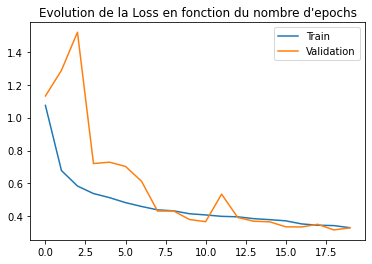

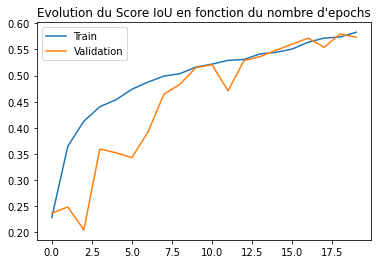

In [103]:
plot_results(metrics_6)

In [104]:
print('Nombre de paramètres du réseau : ', metrics_6['Nombre de paramètres'][0])

Nombre de paramètres du réseau :  23753288


#### Temps de calcul = 3h 02mns

#### Conclusion :
- Ce modèle est supérieur au précédent
- Le score IoU sur le jeu de validation a progressé à 0.57 alors que le temps d'exécution et le nombre de paramètres sont restés stables
- Il n'y a pas d'overfitting
> **C'est à ce stade le meilleur modèle avec le numéro 4**

## Optimisation des hyper paramètres : 
- Afin d'améliorer le modèle, nous avons optimisé les hyper paramètres suivants :
    - Fonction de perte
    - Backbone
    - Architecture du réseau

### Optimisation de la fonction de perte
- La fonction de perte ‘classique’ pour les modèles de classification à plusieurs catégories est la Categorical Cross Entropy
- Cette fonction de perte n'est pas bien adaptée à la segmentation d'images, notamment car elle n'est pas adaptée aux jeux de données déséquilibrés 
- La fonction Dice Loss est beaucoup plus adaptée et utilisée pour la segmentation
- Cette fonction de perte est calculée à partir du coefficient Dice qui est égal à deux fois la zone de chevauchement entre la prédiction et la réalité divisé par le nombre total de pixels de l’image et du masque
- Nous avons donc testé cette fonction de perte **Dice Loss**

###  Optimisation du Backbone
- Nous avons testé les Backbone suivants :
    - Backbone **Resnet**
    - Backbone **Efficientnet**

###  Optimisation de l'architecture du réseau
- Nous avons testé les architectures de réseau suivantes :
    - Architecture **FPN (Features Pyramid Network)**
    - Architecture **Linknet**

### Optimisation de la fonction de perte

### 7 - Modèle : Architecture Unet - Fonction de perte DiceLoss -  Avec augmentation des données - Backbone VGGNet - Poids Imagenet
- Dans ce modèle nous avons remplacé la fonction de perte Categorical Cross Entropy par la fonction de perte Dice Loss

#### Création de l'expérimentation

In [105]:
experiment_name = '7_cityscape_sm_unet_aug_vgg_imagenet_diceloss'

In [106]:
experiment = Experiment(workspace=ws, name=experiment_name)

#### Lancement du script

In [107]:
src = ScriptRunConfig(source_directory=project_folder, 
                      script='7_train_sm_unet_aug_vgg_imagenet_diceloss.py',
                      arguments=script_arguments,
                      compute_target=compute, 
                      environment=environment)

In [108]:
run_7 = experiment.submit(config=src)

In [109]:
run_7

Experiment,Id,Type,Status,Details Page,Docs Page
7_cityscape_sm_unet_aug_vgg_imagenet_diceloss,7_cityscape_sm_unet_aug_vgg_imagenet_diceloss_1633438970_2aaa09cc,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [110]:
%%time
# Shows output of the run on stdout.
run_7.wait_for_completion(show_output=True)

RunId: 7_cityscape_sm_unet_aug_vgg_imagenet_diceloss_1633438970_2aaa09cc
Web View: https://ml.azure.com/runs/7_cityscape_sm_unet_aug_vgg_imagenet_diceloss_1633438970_2aaa09cc?wsid=/subscriptions/dc0050bb-8e50-4b60-8aac-034371ba1a2a/resourcegroups/OC-IA-P8-GPU/workspaces/WS-IA-P8-GPU&tid=894ad120-c276-4dfa-b218-d82b3fece6a7

Streaming azureml-logs/55_azureml-execution-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

2021-10-05T13:02:59Z Running following command: /bin/bash -c sudo blobfuse /mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/7_cityscape_sm_unet_aug_vgg_imagenet_diceloss_1633438970_2aaa09cc/mounts/workspaceblobstore --tmp-path=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/7_cityscape_sm_unet_aug_vgg_imagenet_diceloss_1633438970_2aaa09cc/caches/workspaceblobstore -o ro --file-cache-timeout-in-seconds=1000000 --cache-size-mb=260244 -o nonempty -o allow_other --config-file=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azurem

2021-10-05 13:03:38.264347: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-10-05 13:03:38.987608: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10

74/74 [==============================] - ETA: 0s - loss: 0.5885 - iou_score: 0.3037
Epoch 00001: val_loss improved from inf to 0.64756, saving model to cityscape-sm-unet-aug-vgg-imagenet-diceloss.h5

74/74 [==============================] - 535s 7s/step - loss: 0.5885 - iou_score: 0.3037 - val_loss: 0.6476 - val_iou_score: 0.2370
Epoch 2/20

18/74 [======>.......................] - ETA: 4:33 - loss: 0.4378 - iou_score: 0.4455


74/74 [==============================] - ETA: 0s - loss: 0.4045 - iou_score: 0.4764
Epoch 00002: val_loss improved from 0.64756 to 0.64117, saving model to cityscape-sm-unet-aug-vgg-imagenet-diceloss.h5

74/74 [==============================] - 518s 7s/step - loss: 0.4045 - iou_score: 0.4764 - val_loss: 0.6412 - val_iou_score: 0.2602
Epoch 3/20

42/74 [================>.............] - ETA: 3:01 - loss: 0.3450 - iou_score: 0.5308


74/74 [==============================] - ETA: 0s - loss: 0.3358 - iou_score: 0.5400
Epoch 00003: val_loss did not improve from 0.64117

74/74 [==============================] - 534s 7s/step - loss: 0.3358 - iou_score: 0.5400 - val_loss: 0.6510 - val_iou_score: 0.2621
Epoch 4/20

66/74 [=========================>....] - ETA: 45s - loss: 0.3023 - iou_score: 0.5737


74/74 [==============================] - ETA: 0s - loss: 0.3013 - iou_score: 0.5749
Epoch 00004: val_loss improved from 0.64117 to 0.49893, saving model to cityscape-sm-unet-aug-vgg-imagenet-diceloss.h5

74/74 [==============================] - 518s 7s/step - loss: 0.3013 - iou_score: 0.5749 - val_loss: 0.4989 - val_iou_score: 0.3872
Epoch 5/20

74/74 [==============================] - ETA: 0s - loss: 0.2802 - iou_score: 0.5982
Epoch 00005: val_loss improved from 0.49893 to 0.44822, saving model to cityscape-sm-unet-aug-vgg-imagenet-diceloss.h5

74/74 [==============================] - 527s 7s/step - loss: 0.2802 - iou_score: 0.5982 - val_loss: 0.4482 - val_iou_score: 0.4141
Epoch 6/20

 9/74 [==>...........................] - ETA: 4:57 - loss: 0.2678 - iou_score: 0.6131


74/74 [==============================] - ETA: 0s - loss: 0.2669 - iou_score: 0.6127
Epoch 00006: val_loss improved from 0.44822 to 0.38948, saving model to cityscape-sm-unet-aug-vgg-imagenet-diceloss.h5

74/74 [==============================] - 528s 7s/step - loss: 0.2669 - iou_score: 0.6127 - val_loss: 0.3895 - val_iou_score: 0.4753
Epoch 7/20

31/74 [===========>..................] - ETA: 4:11 - loss: 0.2563 - iou_score: 0.6248


74/74 [==============================] - ETA: 0s - loss: 0.2574 - iou_score: 0.6229
Epoch 00007: val_loss improved from 0.38948 to 0.30753, saving model to cityscape-sm-unet-aug-vgg-imagenet-diceloss.h5

74/74 [==============================] - 550s 7s/step - loss: 0.2574 - iou_score: 0.6229 - val_loss: 0.3075 - val_iou_score: 0.5585
Epoch 8/20

52/74 [====================>.........] - ETA: 2:09 - loss: 0.2465 - iou_score: 0.6361


74/74 [==============================] - ETA: 0s - loss: 0.2455 - iou_score: 0.6372
Epoch 00008: val_loss did not improve from 0.30753

74/74 [==============================] - 548s 7s/step - loss: 0.2455 - iou_score: 0.6372 - val_loss: 0.3125 - val_iou_score: 0.5595
Epoch 9/20

74/74 [==============================] - ETA: 0s - loss: 0.2382 - iou_score: 0.6457


Epoch 00009: val_loss improved from 0.30753 to 0.25623, saving model to cityscape-sm-unet-aug-vgg-imagenet-diceloss.h5

74/74 [==============================] - 527s 7s/step - loss: 0.2382 - iou_score: 0.6457 - val_loss: 0.2562 - val_iou_score: 0.6280
Epoch 10/20

74/74 [==============================] - ETA: 0s - loss: 0.2337 - iou_score: 0.6509
Epoch 00010: val_loss improved from 0.25623 to 0.23358, saving model to cityscape-sm-unet-aug-vgg-imagenet-diceloss.h5

74/74 [==============================] - 533s 7s/step - loss: 0.2337 - iou_score: 0.6509 - val_loss: 0.2336 - val_iou_score: 0.6547
Epoch 11/20

18/74 [======>.......................] - ETA: 4:17 - loss: 0.2323 - iou_score: 0.6518


74/74 [==============================] - ETA: 0s - loss: 0.2269 - iou_score: 0.6586
Epoch 00011: val_loss improved from 0.23358 to 0.23136, saving model to cityscape-sm-unet-aug-vgg-imagenet-diceloss.h5

74/74 [==============================] - 510s 7s/step - loss: 0.2269 - iou_score: 0.6586 - val_loss: 0.2314 - val_iou_score: 0.6538
Epoch 12/20

42/74 [================>.............] - ETA: 3:01 - loss: 0.2208 - iou_score: 0.6662


74/74 [==============================] - ETA: 0s - loss: 0.2210 - iou_score: 0.6655
Epoch 00012: val_loss did not improve from 0.23136

74/74 [==============================] - 532s 7s/step - loss: 0.2210 - iou_score: 0.6655 - val_loss: 0.2327 - val_iou_score: 0.6517
Epoch 13/20

68/74 [==========================>...] - ETA: 33s - loss: 0.2170 - iou_score: 0.6697


74/74 [==============================] - ETA: 0s - loss: 0.2176 - iou_score: 0.6691
Epoch 00013: val_loss improved from 0.23136 to 0.21907, saving model to cityscape-sm-unet-aug-vgg-imagenet-diceloss.h5

74/74 [==============================] - 517s 7s/step - loss: 0.2176 - iou_score: 0.6691 - val_loss: 0.2191 - val_iou_score: 0.6711
Epoch 14/20

74/74 [==============================] - ETA: 0s - loss: 0.2130 - iou_score: 0.6746
Epoch 00014: val_loss improved from 0.21907 to 0.21851, saving model to cityscape-sm-unet-aug-vgg-imagenet-diceloss.h5

74/74 [==============================] - 536s 7s/step - loss: 0.2130 - iou_score: 0.6746 - val_loss: 0.2185 - val_iou_score: 0.6708
Epoch 15/20

21/74 [=======>......................] - ETA: 4:36 - loss: 0.2050 - iou_score: 0.6862


74/74 [==============================] - ETA: 0s - loss: 0.2051 - iou_score: 0.6847
Epoch 00015: val_loss improved from 0.21851 to 0.20948, saving model to cityscape-sm-unet-aug-vgg-imagenet-diceloss.h5

74/74 [==============================] - 534s 7s/step - loss: 0.2051 - iou_score: 0.6847 - val_loss: 0.2095 - val_iou_score: 0.6846
Epoch 16/20

44/74 [================>.............] - ETA: 2:48 - loss: 0.2035 - iou_score: 0.6867


74/74 [==============================] - ETA: 0s - loss: 0.2008 - iou_score: 0.6897
Epoch 00016: val_loss improved from 0.20948 to 0.20491, saving model to cityscape-sm-unet-aug-vgg-imagenet-diceloss.h5

74/74 [==============================] - 517s 7s/step - loss: 0.2008 - iou_score: 0.6897 - val_loss: 0.2049 - val_iou_score: 0.6880
Epoch 17/20

72/74 [============================>.] - ETA: 11s - loss: 0.2009 - iou_score: 0.6896


74/74 [==============================] - ETA: 0s - loss: 0.2007 - iou_score: 0.6898
Epoch 00017: val_loss did not improve from 0.20491

74/74 [==============================] - 515s 7s/step - loss: 0.2007 - iou_score: 0.6898 - val_loss: 0.2189 - val_iou_score: 0.6670
Epoch 18/20

74/74 [==============================] - ETA: 0s - loss: 0.1920 - iou_score: 0.7006
Epoch 00018: val_loss did not improve from 0.20491

74/74 [==============================] - 521s 7s/step - loss: 0.1920 - iou_score: 0.7006 - val_loss: 0.2301 - val_iou_score: 0.6587
Epoch 19/20

18/74 [======>.......................] - ETA: 4:54 - loss: 0.1946 - iou_score: 0.6987


74/74 [==============================] - ETA: 0s - loss: 0.1915 - iou_score: 0.7015
Epoch 00019: val_loss improved from 0.20491 to 0.20354, saving model to cityscape-sm-unet-aug-vgg-imagenet-diceloss.h5

74/74 [==============================] - 523s 7s/step - loss: 0.1915 - iou_score: 0.7015 - val_loss: 0.2035 - val_iou_score: 0.6902
Epoch 20/20

42/74 [================>.............] - ETA: 3:02 - loss: 0.1854 - iou_score: 0.7087


74/74 [==============================] - ETA: 0s - loss: 0.1852 - iou_score: 0.7094
Epoch 00020: val_loss did not improve from 0.20354

74/74 [==============================] - 540s 7s/step - loss: 0.1852 - iou_score: 0.7094 - val_loss: 0.2110 - val_iou_score: 0.6834

Streaming azureml-logs/75_job_post-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

[2021-10-05T16:01:38.022900] Entering job release
[2021-10-05T16:01:38.865857] Starting job release
[2021-10-05T16:01:38.866296] Logging experiment finalizing status in history service.
[2021-10-05T16:01:38.866485] job release stage : upload_datastore starting...Starting the daemon thread to refresh tokens in background for process with pid = 1352

[2021-10-05T16:01:38.866765] job release stage : start importing azureml.history._tracking in run_history_release.
[2021-10-05T16:01:38.867210] job release stage : copy_batchai_cached_logs starting...[2021-10-05T16:01:38.867245] job release stage : execute_job_relea

{'runId': '7_cityscape_sm_unet_aug_vgg_imagenet_diceloss_1633438970_2aaa09cc',
 'target': 'obonheur1',
 'status': 'Completed',
 'startTimeUtc': '2021-10-05T13:02:58.014293Z',
 'endTimeUtc': '2021-10-05T16:01:52.805114Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'f8ba4d08-d08d-4d49-ab9c-800ade6ab97e',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '04ea4a17-f1ee-4144-a1b2-d352f7bf27f6'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__04ea4a17', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': '7_train_sm_unet_aug_vgg_imagenet_diceloss.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-path', 'DatasetConsumptionConfig:input__04ea4a17'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'obonheur1',
  'dataRefer

#### Résultats

In [111]:
metrics_7 = run_7.get_metrics()

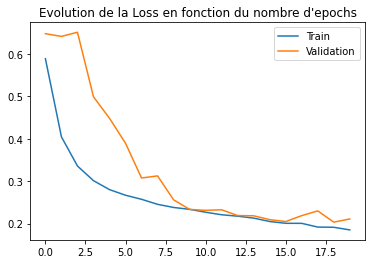

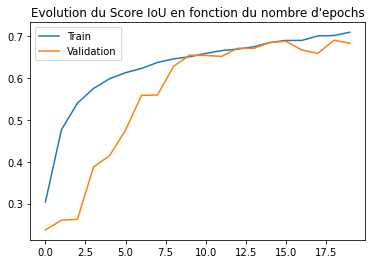

In [112]:
plot_results(metrics_7)

In [113]:
print('Nombre de paramètres du réseau : ', metrics_7['Nombre de paramètres'][0])

Nombre de paramètres du réseau :  23753288


#### Temps de calcul = 2h 58mns

#### Conclusion :
- **La modification de la fonction de perte a été très bénéfique**
- Le score IoU sur le jeu de validation a nettement augmenté à 0.68 et est supérieur à celui des précédents modèles
- Le nombre de paramètre est stable
- Le temps d'éxécution est légèrement inférieur au précédent
- Il n'y a pas d'overfitting (écart de seulement 0.03 entre le score IoU sur le jeu d'entrainement et le jeu de validation à la dernière epoch)
> **C'est le meilleur modèle à ce stade**

###  Optimisation du Backbone

### 8 - Modèle : Architecture Unet - Fonction de perte DiceLoss -  Avec augmentation des données - Backbone Resnet - Poids Imagenet
- Dans ce modèle nous avons changé le backbone pour un backbone Resnet

#### Création de l'expérimentation

In [114]:
experiment_name = '8_cityscape_sm_unet_aug_resnet_imagenet_diceloss'

In [115]:
experiment = Experiment(workspace=ws, name=experiment_name)

#### Lancement du script

In [116]:
src = ScriptRunConfig(source_directory=project_folder, 
                      script='8_train_sm_unet_aug_resnet_imagenet_diceloss.py',
                      arguments=script_arguments,
                      compute_target=compute, 
                      environment=environment)

In [117]:
run_8 = experiment.submit(config=src)

In [118]:
run_8

Experiment,Id,Type,Status,Details Page,Docs Page
8_cityscape_sm_unet_aug_resnet_imagenet_diceloss,8_cityscape_sm_unet_aug_resnet_imagenet_diceloss_1633449998_f7591f8c,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [119]:
%%time
# Shows output of the run on stdout.
run_8.wait_for_completion(show_output=True)

RunId: 8_cityscape_sm_unet_aug_resnet_imagenet_diceloss_1633449998_f7591f8c
Web View: https://ml.azure.com/runs/8_cityscape_sm_unet_aug_resnet_imagenet_diceloss_1633449998_f7591f8c?wsid=/subscriptions/dc0050bb-8e50-4b60-8aac-034371ba1a2a/resourcegroups/OC-IA-P8-GPU/workspaces/WS-IA-P8-GPU&tid=894ad120-c276-4dfa-b218-d82b3fece6a7

Streaming azureml-logs/55_azureml-execution-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

2021-10-05T16:06:48Z Running following command: /bin/bash -c sudo blobfuse /mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/8_cityscape_sm_unet_aug_resnet_imagenet_diceloss_1633449998_f7591f8c/mounts/workspaceblobstore --tmp-path=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/8_cityscape_sm_unet_aug_resnet_imagenet_diceloss_1633449998_f7591f8c/caches/workspaceblobstore -o ro --file-cache-timeout-in-seconds=1000000 --cache-size-mb=260243 -o nonempty -o allow_other --config-file=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p

Epoch 1/20
2021-10-05 16:07:32.676147: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-10-05 16:07:33.348613: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10

74/74 [==============================] - ETA: 0s - loss: 0.5132 - iou_score: 0.3735
Epoch 00001: val_loss improved from inf to 0.67100, saving model to cityscape-sm-unet-aug-resnet-imagenet-diceloss.h5

74/74 [==============================] - 497s 7s/step - loss: 0.5132 - iou_score: 0.3735 - val_loss: 0.6710 - val_iou_score: 0.2163
Epoch 2/20

24/74 [========>.....................] - ETA: 3:49 - loss: 0.3365 - iou_score: 0.5434


74/74 [==============================] - ETA: 0s - loss: 0.3130 - iou_score: 0.5668
Epoch 00002: val_loss improved from 0.67100 to 0.59583, saving model to cityscape-sm-unet-aug-resnet-imagenet-diceloss.h5

74/74 [==============================] - 475s 6s/step - loss: 0.3130 - iou_score: 0.5668 - val_loss: 0.5958 - val_iou_score: 0.2780
Epoch 3/20

46/74 [=================>............] - ETA: 2:28 - loss: 0.2774 - iou_score: 0.6038


74/74 [==============================] - ETA: 0s - loss: 0.2756 - iou_score: 0.6045
Epoch 00003: val_loss improved from 0.59583 to 0.38005, saving model to cityscape-sm-unet-aug-resnet-imagenet-diceloss.h5

74/74 [==============================] - 488s 7s/step - loss: 0.2756 - iou_score: 0.6045 - val_loss: 0.3801 - val_iou_score: 0.4877
Epoch 4/20

67/74 [==========================>...] - ETA: 36s - loss: 0.2485 - iou_score: 0.6354


74/74 [==============================] - ETA: 0s - loss: 0.2489 - iou_score: 0.6351
Epoch 00004: val_loss improved from 0.38005 to 0.28307, saving model to cityscape-sm-unet-aug-resnet-imagenet-diceloss.h5

74/74 [==============================] - 482s 7s/step - loss: 0.2489 - iou_score: 0.6351 - val_loss: 0.2831 - val_iou_score: 0.6001
Epoch 5/20

74/74 [==============================] - ETA: 0s - loss: 0.2335 - iou_score: 0.6524
Epoch 00005: val_loss improved from 0.28307 to 0.24458, saving model to cityscape-sm-unet-aug-resnet-imagenet-diceloss.h5

74/74 [==============================] - 490s 7s/step - loss: 0.2335 - iou_score: 0.6524 - val_loss: 0.2446 - val_iou_score: 0.6464
Epoch 6/20

21/74 [=======>......................] - ETA: 4:26 - loss: 0.2220 - iou_score: 0.6664


74/74 [==============================] - ETA: 0s - loss: 0.2212 - iou_score: 0.6667
Epoch 00006: val_loss did not improve from 0.24458

74/74 [==============================] - 488s 7s/step - loss: 0.2212 - iou_score: 0.6667 - val_loss: 0.2555 - val_iou_score: 0.6409
Epoch 7/20

45/74 [=================>............] - ETA: 2:28 - loss: 0.2163 - iou_score: 0.6735


74/74 [==============================] - ETA: 0s - loss: 0.2216 - iou_score: 0.6662
Epoch 00007: val_loss did not improve from 0.24458

74/74 [==============================] - 493s 7s/step - loss: 0.2216 - iou_score: 0.6662 - val_loss: 0.3656 - val_iou_score: 0.4992
Epoch 8/20

74/74 [==============================] - ETA: 0s - loss: 0.2153 - iou_score: 0.6731


Epoch 00008: val_loss improved from 0.24458 to 0.22186, saving model to cityscape-sm-unet-aug-resnet-imagenet-diceloss.h5

74/74 [==============================] - 501s 7s/step - loss: 0.2153 - iou_score: 0.6731 - val_loss: 0.2219 - val_iou_score: 0.6732
Epoch 9/20

74/74 [==============================] - ETA: 0s - loss: 0.2021 - iou_score: 0.6898
Epoch 00009: val_loss did not improve from 0.22186

74/74 [==============================] - 497s 7s/step - loss: 0.2021 - iou_score: 0.6898 - val_loss: 0.2323 - val_iou_score: 0.6592
Epoch 10/20

28/74 [==========>...................] - ETA: 3:47 - loss: 0.2002 - iou_score: 0.6931


74/74 [==============================] - ETA: 0s - loss: 0.1997 - iou_score: 0.6927
Epoch 00010: val_loss did not improve from 0.22186

74/74 [==============================] - 487s 7s/step - loss: 0.1997 - iou_score: 0.6927 - val_loss: 0.2261 - val_iou_score: 0.6654
Epoch 11/20

50/74 [===================>..........] - ETA: 2:03 - loss: 0.1948 - iou_score: 0.6987


74/74 [==============================] - ETA: 0s - loss: 0.1935 - iou_score: 0.7004
Epoch 00011: val_loss improved from 0.22186 to 0.21183, saving model to cityscape-sm-unet-aug-resnet-imagenet-diceloss.h5

74/74 [==============================] - 483s 7s/step - loss: 0.1935 - iou_score: 0.7004 - val_loss: 0.2118 - val_iou_score: 0.6828
Epoch 12/20

73/74 [============================>.] - ETA: 5s - loss: 0.1940 - iou_score: 0.6997 


74/74 [==============================] - ETA: 0s - loss: 0.1944 - iou_score: 0.6991
Epoch 00012: val_loss did not improve from 0.21183

74/74 [==============================] - 485s 7s/step - loss: 0.1944 - iou_score: 0.6991 - val_loss: 0.2367 - val_iou_score: 0.6520
Epoch 13/20

74/74 [==============================] - ETA: 0s - loss: 0.1948 - iou_score: 0.6983
Epoch 00013: val_loss did not improve from 0.21183

74/74 [==============================] - 485s 7s/step - loss: 0.1948 - iou_score: 0.6983 - val_loss: 0.2160 - val_iou_score: 0.6804
Epoch 14/20

17/74 [=====>........................] - ETA: 4:19 - loss: 0.1872 - iou_score: 0.7075


74/74 [==============================] - ETA: 0s - loss: 0.1905 - iou_score: 0.7040
Epoch 00014: val_loss did not improve from 0.21183

74/74 [==============================] - 487s 7s/step - loss: 0.1905 - iou_score: 0.7040 - val_loss: 0.2127 - val_iou_score: 0.6823
Epoch 15/20

38/74 [==============>...............] - ETA: 3:11 - loss: 0.1872 - iou_score: 0.7071


74/74 [==============================] - ETA: 0s - loss: 0.1839 - iou_score: 0.7120
Epoch 00015: val_loss did not improve from 0.21183

74/74 [==============================] - 496s 7s/step - loss: 0.1839 - iou_score: 0.7120 - val_loss: 0.2206 - val_iou_score: 0.6723
Epoch 16/20

60/74 [=======================>......] - ETA: 1:14 - loss: 0.1842 - iou_score: 0.7112


74/74 [==============================] - ETA: 0s - loss: 0.1832 - iou_score: 0.7125
Epoch 00016: val_loss improved from 0.21183 to 0.20350, saving model to cityscape-sm-unet-aug-resnet-imagenet-diceloss.h5

74/74 [==============================] - 489s 7s/step - loss: 0.1832 - iou_score: 0.7125 - val_loss: 0.2035 - val_iou_score: 0.6928
Epoch 17/20

74/74 [==============================] - ETA: 0s - loss: 0.1780 - iou_score: 0.7194
Epoch 00017: val_loss did not improve from 0.20350

74/74 [==============================] - 471s 6s/step - loss: 0.1780 - iou_score: 0.7194 - val_loss: 0.2046 - val_iou_score: 0.6933
Epoch 18/20

19/74 [======>.......................] - ETA: 4:04 - loss: 0.1757 - iou_score: 0.7227


74/74 [==============================] - ETA: 0s - loss: 0.1756 - iou_score: 0.7226
Epoch 00018: val_loss did not improve from 0.20350

74/74 [==============================] - 470s 6s/step - loss: 0.1756 - iou_score: 0.7226 - val_loss: 0.2046 - val_iou_score: 0.6904
Epoch 19/20

43/74 [================>.............] - ETA: 2:32 - loss: 0.1731 - iou_score: 0.7258


74/74 [==============================] - ETA: 0s - loss: 0.1717 - iou_score: 0.7278
Epoch 00019: val_loss improved from 0.20350 to 0.19787, saving model to cityscape-sm-unet-aug-resnet-imagenet-diceloss.h5

74/74 [==============================] - 469s 6s/step - loss: 0.1717 - iou_score: 0.7278 - val_loss: 0.1979 - val_iou_score: 0.7002
Epoch 20/20

67/74 [==========================>...] - ETA: 36s - loss: 0.1702 - iou_score: 0.7293


74/74 [==============================] - ETA: 0s - loss: 0.1699 - iou_score: 0.7298
Epoch 00020: val_loss did not improve from 0.19787

74/74 [==============================] - 484s 7s/step - loss: 0.1699 - iou_score: 0.7298 - val_loss: 0.1999 - val_iou_score: 0.6986


[2021-10-05T18:51:14.982958] The experiment completed successfully. Finalizing run...
Cleaning up all outstanding Run operations, waiting 900.0 seconds
3 items cleaning up...
Cleanup took 0.4651525020599365 seconds
[2021-10-05T18:51:15.583643] Finished context manager injector.

Streaming azureml-logs/75_job_post-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

[2021-10-05T18:51:18.586624] Entering job release
[2021-10-05T18:51:19.382436] Starting job release
[2021-10-05T18:51:19.382849] Logging experiment finalizing status in history service.[2021-10-05T18:51:19.383015] job release stage : upload_datastore starting...

Starting the daemon thread to refresh tokens in background for process w

{'runId': '8_cityscape_sm_unet_aug_resnet_imagenet_diceloss_1633449998_f7591f8c',
 'target': 'obonheur1',
 'status': 'Completed',
 'startTimeUtc': '2021-10-05T16:06:48.004707Z',
 'endTimeUtc': '2021-10-05T18:51:32.196762Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'f8ba4d08-d08d-4d49-ab9c-800ade6ab97e',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '04ea4a17-f1ee-4144-a1b2-d352f7bf27f6'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__04ea4a17', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': '8_train_sm_unet_aug_resnet_imagenet_diceloss.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-path', 'DatasetConsumptionConfig:input__04ea4a17'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'obonheur1',
  'dat

#### Résultats

In [120]:
metrics_8 = run_8.get_metrics()

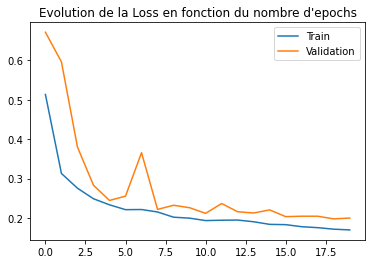

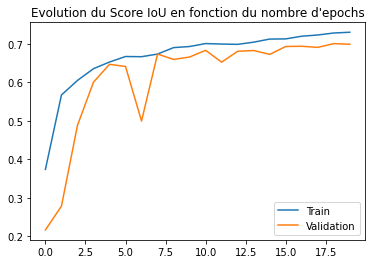

In [121]:
plot_results(metrics_8)

In [122]:
print('Nombre de paramètres du réseau : ', metrics_8['Nombre de paramètres'][0])

Nombre de paramètres du réseau :  24457169


#### Temps de calcul = 2h 44mns

#### Conclusion :
- **La modification du backbone a été très bénéfique : le backbone Resnet a amélioré l'apprentissage**
- Le score IoU sur le jeu de validation a progressé à 0.70
- Le temps d'exécution ainsi que le nombre de paramètres ont diminué
- Il n'y a pas d'overfitting (écart de seulement 0.03 entre le score IoU sur le jeu d'entrainement et le jeu de validation à la dernière epoch)
> **C'est le meilleur modèle à ce stade**

### 9 - Modèle : Architecture Unet - Fonction de perte DiceLoss -  Avec augmentation des données - Backbone Efficientnet - Poids Imagenet
- Dans ce modèle nous avons changé le backbone pour un backbone Efficientnet

#### Création de l'expérimentation

In [123]:
experiment_name = '9_cityscape_sm_unet_aug_efficientnet_imagenet_diceloss'

In [124]:
experiment = Experiment(workspace=ws, name=experiment_name)

#### Lancement du script

In [129]:
src = ScriptRunConfig(source_directory=project_folder, 
                      script='9_train_sm_unet_aug_efficientnet_imagenet_diceloss.py',
                      arguments=script_arguments,
                      compute_target=compute, 
                      environment=environment)

In [130]:
run_9 = experiment.submit(config=src)

In [131]:
run_9

Experiment,Id,Type,Status,Details Page,Docs Page
9_cityscape_sm_unet_aug_efficientnet_imagenet_diceloss,9_cityscape_sm_unet_aug_efficientnet_imagenet_diceloss_1633460137_b5423f9f,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [132]:
%%time
# Shows output of the run on stdout.
run_9.wait_for_completion(show_output=True)

RunId: 9_cityscape_sm_unet_aug_efficientnet_imagenet_diceloss_1633460137_b5423f9f
Web View: https://ml.azure.com/runs/9_cityscape_sm_unet_aug_efficientnet_imagenet_diceloss_1633460137_b5423f9f?wsid=/subscriptions/dc0050bb-8e50-4b60-8aac-034371ba1a2a/resourcegroups/OC-IA-P8-GPU/workspaces/WS-IA-P8-GPU&tid=894ad120-c276-4dfa-b218-d82b3fece6a7

Streaming azureml-logs/55_azureml-execution-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

2021-10-05T18:55:53Z Running following command: /bin/bash -c sudo blobfuse /mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/9_cityscape_sm_unet_aug_efficientnet_imagenet_diceloss_1633460137_b5423f9f/mounts/workspaceblobstore --tmp-path=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/9_cityscape_sm_unet_aug_efficientnet_imagenet_diceloss_1633460137_b5423f9f/caches/workspaceblobstore -o ro --file-cache-timeout-in-seconds=1000000 --cache-size-mb=260241 -o nonempty -o allow_other --config-file=/mnt/batch/tasks/sha

Epoch 1/20
2021-10-05 18:56:51.830486: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-10-05 18:56:52.492171: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10

74/74 [==============================] - ETA: 0s - loss: 0.5197 - iou_score: 0.3755
Epoch 00001: val_loss improved from inf to 0.58132, saving model to cityscape-sm-unet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 549s 7s/step - loss: 0.5197 - iou_score: 0.3755 - val_loss: 0.5813 - val_iou_score: 0.2943
Epoch 2/20

19/74 [======>.......................] - ETA: 4:54 - loss: 0.3443 - iou_score: 0.5442


74/74 [==============================] - ETA: 0s - loss: 0.3004 - iou_score: 0.5868
Epoch 00002: val_loss improved from 0.58132 to 0.35883, saving model to cityscape-sm-unet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 544s 7s/step - loss: 0.3004 - iou_score: 0.5868 - val_loss: 0.3588 - val_iou_score: 0.5175
Epoch 3/20

46/74 [=================>............] - ETA: 2:43 - loss: 0.2472 - iou_score: 0.6383


74/74 [==============================] - ETA: 0s - loss: 0.2421 - iou_score: 0.6446
Epoch 00003: val_loss improved from 0.35883 to 0.29219, saving model to cityscape-sm-unet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 545s 7s/step - loss: 0.2421 - iou_score: 0.6446 - val_loss: 0.2922 - val_iou_score: 0.5966
Epoch 4/20

74/74 [==============================] - ETA: 0s - loss: 0.2192 - iou_score: 0.6703


Epoch 00004: val_loss improved from 0.29219 to 0.24005, saving model to cityscape-sm-unet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 553s 7s/step - loss: 0.2192 - iou_score: 0.6703 - val_loss: 0.2400 - val_iou_score: 0.6516
Epoch 5/20

74/74 [==============================] - ETA: 0s - loss: 0.2083 - iou_score: 0.6829
Epoch 00005: val_loss improved from 0.24005 to 0.23850, saving model to cityscape-sm-unet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 531s 7s/step - loss: 0.2083 - iou_score: 0.6829 - val_loss: 0.2385 - val_iou_score: 0.6525
Epoch 6/20

25/74 [=========>....................] - ETA: 4:52 - loss: 0.1927 - iou_score: 0.7026


74/74 [==============================] - ETA: 0s - loss: 0.1967 - iou_score: 0.6974
Epoch 00006: val_loss improved from 0.23850 to 0.21381, saving model to cityscape-sm-unet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 558s 8s/step - loss: 0.1967 - iou_score: 0.6974 - val_loss: 0.2138 - val_iou_score: 0.6807
Epoch 7/20

52/74 [====================>.........] - ETA: 2:14 - loss: 0.1911 - iou_score: 0.7039


74/74 [==============================] - ETA: 0s - loss: 0.1913 - iou_score: 0.7036
Epoch 00007: val_loss improved from 0.21381 to 0.20339, saving model to cityscape-sm-unet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 564s 8s/step - loss: 0.1913 - iou_score: 0.7036 - val_loss: 0.2034 - val_iou_score: 0.6928
Epoch 8/20

72/74 [============================>.] - ETA: 11s - loss: 0.1861 - iou_score: 0.7098


74/74 [==============================] - ETA: 0s - loss: 0.1863 - iou_score: 0.7097
Epoch 00008: val_loss improved from 0.20339 to 0.19842, saving model to cityscape-sm-unet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 539s 7s/step - loss: 0.1863 - iou_score: 0.7097 - val_loss: 0.1984 - val_iou_score: 0.6972
Epoch 9/20

74/74 [==============================] - ETA: 0s - loss: 0.1819 - iou_score: 0.7153
Epoch 00009: val_loss did not improve from 0.19842

74/74 [==============================] - 537s 7s/step - loss: 0.1819 - iou_score: 0.7153 - val_loss: 0.1999 - val_iou_score: 0.7003
Epoch 10/20

26/74 [=========>....................] - ETA: 4:36 - loss: 0.1745 - iou_score: 0.7247


74/74 [==============================] - ETA: 0s - loss: 0.1753 - iou_score: 0.7237
Epoch 00010: val_loss improved from 0.19842 to 0.19217, saving model to cityscape-sm-unet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 534s 7s/step - loss: 0.1753 - iou_score: 0.7237 - val_loss: 0.1922 - val_iou_score: 0.7068
Epoch 11/20

49/74 [==================>...........] - ETA: 2:23 - loss: 0.1692 - iou_score: 0.7315


74/74 [==============================] - ETA: 0s - loss: 0.1717 - iou_score: 0.7283
Epoch 00011: val_loss did not improve from 0.19217

74/74 [==============================] - 524s 7s/step - loss: 0.1717 - iou_score: 0.7283 - val_loss: 0.1930 - val_iou_score: 0.7052
Epoch 12/20

74/74 [==============================] - ETA: 0s - loss: 0.1677 - iou_score: 0.7336


Epoch 00012: val_loss did not improve from 0.19217

74/74 [==============================] - 528s 7s/step - loss: 0.1677 - iou_score: 0.7336 - val_loss: 0.1936 - val_iou_score: 0.7065
Epoch 13/20

74/74 [==============================] - ETA: 0s - loss: 0.1639 - iou_score: 0.7383
Epoch 00013: val_loss improved from 0.19217 to 0.18449, saving model to cityscape-sm-unet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 543s 7s/step - loss: 0.1639 - iou_score: 0.7383 - val_loss: 0.1845 - val_iou_score: 0.7165
Epoch 14/20

22/74 [=======>......................] - ETA: 4:53 - loss: 0.1661 - iou_score: 0.7355


74/74 [==============================] - ETA: 0s - loss: 0.1658 - iou_score: 0.7359
Epoch 00014: val_loss improved from 0.18449 to 0.18054, saving model to cityscape-sm-unet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 556s 8s/step - loss: 0.1658 - iou_score: 0.7359 - val_loss: 0.1805 - val_iou_score: 0.7194
Epoch 15/20

48/74 [==================>...........] - ETA: 2:41 - loss: 0.1617 - iou_score: 0.7412


74/74 [==============================] - ETA: 0s - loss: 0.1632 - iou_score: 0.7394
Epoch 00015: val_loss improved from 0.18054 to 0.17935, saving model to cityscape-sm-unet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 570s 8s/step - loss: 0.1632 - iou_score: 0.7394 - val_loss: 0.1793 - val_iou_score: 0.7224
Epoch 16/20

74/74 [==============================] - ETA: 0s - loss: 0.1585 - iou_score: 0.7456


Epoch 00016: val_loss improved from 0.17935 to 0.17794, saving model to cityscape-sm-unet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 557s 8s/step - loss: 0.1585 - iou_score: 0.7456 - val_loss: 0.1779 - val_iou_score: 0.7240
Epoch 17/20

74/74 [==============================] - ETA: 0s - loss: 0.1566 - iou_score: 0.7479
Epoch 00017: val_loss did not improve from 0.17794

74/74 [==============================] - 556s 8s/step - loss: 0.1566 - iou_score: 0.7479 - val_loss: 0.1803 - val_iou_score: 0.7211
Epoch 18/20

24/74 [========>.....................] - ETA: 4:30 - loss: 0.1558 - iou_score: 0.7484


74/74 [==============================] - ETA: 0s - loss: 0.1549 - iou_score: 0.7501
Epoch 00018: val_loss did not improve from 0.17794

74/74 [==============================] - 544s 7s/step - loss: 0.1549 - iou_score: 0.7501 - val_loss: 0.1784 - val_iou_score: 0.7234
Epoch 19/20

52/74 [====================>.........] - ETA: 2:11 - loss: 0.1520 - iou_score: 0.7536


74/74 [==============================] - ETA: 0s - loss: 0.1540 - iou_score: 0.7510
Epoch 00019: val_loss did not improve from 0.17794

74/74 [==============================] - 559s 8s/step - loss: 0.1540 - iou_score: 0.7510 - val_loss: 0.1788 - val_iou_score: 0.7237
Epoch 20/20

74/74 [==============================] - ETA: 0s - loss: 0.1522 - iou_score: 0.7536



Streaming azureml-logs/75_job_post-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

[2021-10-05T22:01:27.897976] Entering job release
[2021-10-05T22:01:28.703531] Starting job release
[2021-10-05T22:01:28.704474] Logging experiment finalizing status in history service.
Starting the daemon thread to refresh tokens in background for process with pid = 1393[2021-10-05T22:01:28.704732] job release stage : upload_datastore starting...
[2021-10-05T22:01:28.704932] job release stage : start importing azureml.history._tracking in run_history_release.
[2021-10-05T22:01:28.704978] job release stage : execute_job_release starting...

[2021-10-05T22:01:28.707566] job release stage : copy_batchai_cached_logs starting...
[2021-10-05T22:01:28.708178] job release stage : copy_batchai_cached_logs completed...
[2021-10-05T22:01:28.718429] Entering context manager injector.
[2021-10-05T22:01:28.722698] job release stage : upload_datastore completed...
[2021-10-05T22:01:28.80

{'runId': '9_cityscape_sm_unet_aug_efficientnet_imagenet_diceloss_1633460137_b5423f9f',
 'target': 'obonheur1',
 'status': 'Completed',
 'startTimeUtc': '2021-10-05T18:55:53.021602Z',
 'endTimeUtc': '2021-10-05T22:01:40.079486Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '3abc6dc3-f09b-400e-96d7-126f77520eaf',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '04ea4a17-f1ee-4144-a1b2-d352f7bf27f6'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__04ea4a17', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': '9_train_sm_unet_aug_efficientnet_imagenet_diceloss.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-path', 'DatasetConsumptionConfig:input__04ea4a17'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'obonhe

#### Résultats

In [133]:
metrics_9 = run_9.get_metrics()

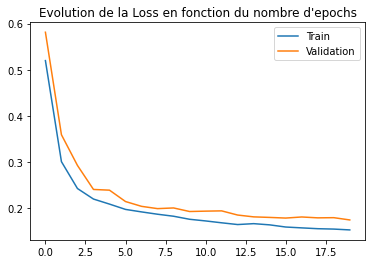

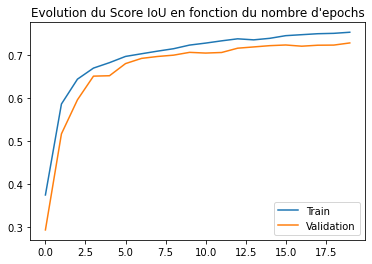

In [134]:
plot_results(metrics_9)

In [135]:
print('Nombre de paramètres du réseau : ', metrics_9['Nombre de paramètres'][0])

Nombre de paramètres du réseau :  17868848


#### Temps de calcul = 3h 05mns

#### Conclusion :
- **La modification du backbone a été bénéfique : le backbone EfficientNet a amélioré l'apprentissage**
- Le score IoU sur le jeu de validation a progressé à 0.73
- Le nombre de paramètres a diminué (ce qui est logique car le principe des réseaux EfficientNet est d'optimiser le nombre de paramètres)
- Le temps d'exécution est très légèrement supérieur
- Il n'y a pas d'overfitting (écart de seulement 0.03 entre le score IoU sur le jeu d'entrainement et le jeu de validation à la dernière epoch)
- **Le backbone EfficientNet est le meilleur parmi les 3 essayés, c'est donc celui-ci que nous retenons**
> **C'est le meilleur modèle à ce stade**

### Optimisation de l'archictures du réseau

### 10 - Modèle : Architecture FPN - Fonction de perte DiceLoss -  Avec augmentation des données - Backbone Efficientnet - Poids Imagenet
- Dans ce modèle nous avons changé l'architecture pour une architecture de type FPN (Features Pyramid Network)

#### Création de l'expérimentation

In [136]:
experiment_name = '10_cityscape_sm_fpn_aug_efficientnet_imagenet_diceloss'

In [137]:
experiment = Experiment(workspace=ws, name=experiment_name)

#### Lancement du script

In [138]:
src = ScriptRunConfig(source_directory=project_folder, 
                      script='10_train_sm_fpn_aug_efficientnet_imagenet_diceloss.py',
                      arguments=script_arguments,
                      compute_target=compute, 
                      environment=environment)

In [139]:
run_10 = experiment.submit(config=src)

In [140]:
run_10

Experiment,Id,Type,Status,Details Page,Docs Page
10_cityscape_sm_fpn_aug_efficientnet_imagenet_diceloss,10_cityscape_sm_fpn_aug_efficientnet_imagenet_diceloss_1633504629_fbbb6a20,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [141]:
%%time
# Shows output of the run on stdout.
run_10.wait_for_completion(show_output=True)

RunId: 10_cityscape_sm_fpn_aug_efficientnet_imagenet_diceloss_1633504629_fbbb6a20
Web View: https://ml.azure.com/runs/10_cityscape_sm_fpn_aug_efficientnet_imagenet_diceloss_1633504629_fbbb6a20?wsid=/subscriptions/dc0050bb-8e50-4b60-8aac-034371ba1a2a/resourcegroups/OC-IA-P8-GPU/workspaces/WS-IA-P8-GPU&tid=894ad120-c276-4dfa-b218-d82b3fece6a7

Streaming azureml-logs/55_azureml-execution-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

2021-10-06T07:17:25Z Running following command: /bin/bash -c sudo blobfuse /mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/10_cityscape_sm_fpn_aug_efficientnet_imagenet_diceloss_1633504629_fbbb6a20/mounts/workspaceblobstore --tmp-path=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/10_cityscape_sm_fpn_aug_efficientnet_imagenet_diceloss_1633504629_fbbb6a20/caches/workspaceblobstore -o ro --file-cache-timeout-in-seconds=1000000 --cache-size-mb=260246 -o nonempty -o allow_other --config-file=/mnt/batch/tasks/sha


Streaming azureml-logs/70_driver_log.txt

bash: /azureml-envs/azureml_1e5a6148f062de911cc865d14d4aee17/lib/libtinfo.so.5: no version information available (required by bash)
2021/10/06 07:19:19 Got JobInfoJson from env
2021/10/06 07:19:19 Starting App Insight Logger for task:  runTaskLet
2021/10/06 07:19:19 Version: 3.0.01734.0003 Branch: .SourceBranch Commit: 21dafbb
2021/10/06 07:19:19 Attempt 1 of http call to http://10.0.0.4:16384/sendlogstoartifacts/info
bash: /azureml-envs/azureml_1e5a6148f062de911cc865d14d4aee17/lib/libtinfo.so.5: no version information available (required by bash)
2021/10/06 07:19:19 Send process info logs to master server succeeded
2021/10/06 07:19:19 Attempt 1 of http call to http://10.0.0.4:16384/sendlogstoartifacts/status
2021/10/06 07:19:19 Send process info logs to master server succeeded
[2021-10-06T07:19:19.076462] Entering context manager injector.
[2021-10-06T07:19:19.730755] context_manager_injector.py Command line Options: Namespace(inject=['Projec


74/74 [==============================] - ETA: 0s - loss: 0.3254 - iou_score: 0.5561
Epoch 00001: val_loss improved from inf to 0.40769, saving model to cityscape-sm-fpn-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 604s 8s/step - loss: 0.3254 - iou_score: 0.5561 - val_loss: 0.4077 - val_iou_score: 0.4487
Epoch 2/20

29/74 [==========>...................] - ETA: 3:13 - loss: 0.2413 - iou_score: 0.6452


74/74 [==============================] - ETA: 0s - loss: 0.2382 - iou_score: 0.6472
Epoch 00002: val_loss improved from 0.40769 to 0.26497, saving model to cityscape-sm-fpn-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 383s 5s/step - loss: 0.2382 - iou_score: 0.6472 - val_loss: 0.2650 - val_iou_score: 0.6179
Epoch 3/20

53/74 [====================>.........] - ETA: 1:31 - loss: 0.2169 - iou_score: 0.6716


74/74 [==============================] - ETA: 0s - loss: 0.2166 - iou_score: 0.6727
Epoch 00003: val_loss improved from 0.26497 to 0.23245, saving model to cityscape-sm-fpn-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 382s 5s/step - loss: 0.2166 - iou_score: 0.6727 - val_loss: 0.2324 - val_iou_score: 0.6616
Epoch 4/20

74/74 [==============================] - ETA: 0s - loss: 0.1995 - iou_score: 0.6929


Epoch 00004: val_loss improved from 0.23245 to 0.22580, saving model to cityscape-sm-fpn-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 383s 5s/step - loss: 0.1995 - iou_score: 0.6929 - val_loss: 0.2258 - val_iou_score: 0.6686
Epoch 5/20

74/74 [==============================] - ETA: 0s - loss: 0.1900 - iou_score: 0.7045
Epoch 00005: val_loss improved from 0.22580 to 0.19960, saving model to cityscape-sm-fpn-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 384s 5s/step - loss: 0.1900 - iou_score: 0.7045 - val_loss: 0.1996 - val_iou_score: 0.6960
Epoch 6/20

25/74 [=========>....................] - ETA: 3:31 - loss: 0.1870 - iou_score: 0.7076


74/74 [==============================] - ETA: 0s - loss: 0.1845 - iou_score: 0.7112
Epoch 00006: val_loss did not improve from 0.19960

74/74 [==============================] - 383s 5s/step - loss: 0.1845 - iou_score: 0.7112 - val_loss: 0.2146 - val_iou_score: 0.6790
Epoch 7/20

46/74 [=================>............] - ETA: 2:02 - loss: 0.1793 - iou_score: 0.7178


74/74 [==============================] - ETA: 0s - loss: 0.1762 - iou_score: 0.7221
Epoch 00007: val_loss did not improve from 0.19960

74/74 [==============================] - 382s 5s/step - loss: 0.1762 - iou_score: 0.7221 - val_loss: 0.2027 - val_iou_score: 0.6964
Epoch 8/20

70/74 [===========================>..] - ETA: 17s - loss: 0.1693 - iou_score: 0.7311


74/74 [==============================] - ETA: 0s - loss: 0.1692 - iou_score: 0.7312
Epoch 00008: val_loss improved from 0.19960 to 0.19719, saving model to cityscape-sm-fpn-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 382s 5s/step - loss: 0.1692 - iou_score: 0.7312 - val_loss: 0.1972 - val_iou_score: 0.7028
Epoch 9/20

74/74 [==============================] - ETA: 0s - loss: 0.1674 - iou_score: 0.7339
Epoch 00009: val_loss improved from 0.19719 to 0.18760, saving model to cityscape-sm-fpn-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 382s 5s/step - loss: 0.1674 - iou_score: 0.7339 - val_loss: 0.1876 - val_iou_score: 0.7108
Epoch 10/20

21/74 [=======>......................] - ETA: 3:45 - loss: 0.1593 - iou_score: 0.7444


74/74 [==============================] - ETA: 0s - loss: 0.1596 - iou_score: 0.7438
Epoch 00010: val_loss improved from 0.18760 to 0.18320, saving model to cityscape-sm-fpn-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 384s 5s/step - loss: 0.1596 - iou_score: 0.7438 - val_loss: 0.1832 - val_iou_score: 0.7164
Epoch 11/20

46/74 [=================>............] - ETA: 2:02 - loss: 0.1551 - iou_score: 0.7499


74/74 [==============================] - ETA: 0s - loss: 0.1564 - iou_score: 0.7482
Epoch 00011: val_loss improved from 0.18320 to 0.18009, saving model to cityscape-sm-fpn-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 381s 5s/step - loss: 0.1564 - iou_score: 0.7482 - val_loss: 0.1801 - val_iou_score: 0.7207
Epoch 12/20

70/74 [===========================>..] - ETA: 17s - loss: 0.1553 - iou_score: 0.7494


74/74 [==============================] - ETA: 0s - loss: 0.1561 - iou_score: 0.7483
Epoch 00012: val_loss did not improve from 0.18009

74/74 [==============================] - 381s 5s/step - loss: 0.1561 - iou_score: 0.7483 - val_loss: 0.1805 - val_iou_score: 0.7208
Epoch 13/20

74/74 [==============================] - ETA: 0s - loss: 0.1497 - iou_score: 0.7569
Epoch 00013: val_loss improved from 0.18009 to 0.17449, saving model to cityscape-sm-fpn-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 382s 5s/step - loss: 0.1497 - iou_score: 0.7569 - val_loss: 0.1745 - val_iou_score: 0.7279
Epoch 14/20

21/74 [=======>......................] - ETA: 3:44 - loss: 0.1477 - iou_score: 0.7593


74/74 [==============================] - ETA: 0s - loss: 0.1472 - iou_score: 0.7604
Epoch 00014: val_loss did not improve from 0.17449

74/74 [==============================] - 381s 5s/step - loss: 0.1472 - iou_score: 0.7604 - val_loss: 0.1751 - val_iou_score: 0.7273
Epoch 15/20

46/74 [=================>............] - ETA: 2:01 - loss: 0.1414 - iou_score: 0.7685


74/74 [==============================] - ETA: 0s - loss: 0.1433 - iou_score: 0.7656
Epoch 00015: val_loss improved from 0.17449 to 0.17342, saving model to cityscape-sm-fpn-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 382s 5s/step - loss: 0.1433 - iou_score: 0.7656 - val_loss: 0.1734 - val_iou_score: 0.7280
Epoch 16/20

67/74 [==========================>...] - ETA: 30s - loss: 0.1440 - iou_score: 0.7642


74/74 [==============================] - ETA: 0s - loss: 0.1429 - iou_score: 0.7658
Epoch 00016: val_loss did not improve from 0.17342

74/74 [==============================] - 381s 5s/step - loss: 0.1429 - iou_score: 0.7658 - val_loss: 0.1749 - val_iou_score: 0.7282
Epoch 17/20

74/74 [==============================] - ETA: 0s - loss: 0.1400 - iou_score: 0.7699
Epoch 00017: val_loss did not improve from 0.17342

74/74 [==============================] - 380s 5s/step - loss: 0.1400 - iou_score: 0.7699 - val_loss: 0.1789 - val_iou_score: 0.7246
Epoch 18/20

19/74 [======>.......................] - ETA: 3:51 - loss: 0.1352 - iou_score: 0.7775


74/74 [==============================] - ETA: 0s - loss: 0.1405 - iou_score: 0.7693
Epoch 00018: val_loss improved from 0.17342 to 0.17123, saving model to cityscape-sm-fpn-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 382s 5s/step - loss: 0.1405 - iou_score: 0.7693 - val_loss: 0.1712 - val_iou_score: 0.7319
Epoch 19/20

40/74 [===============>..............] - ETA: 2:27 - loss: 0.1373 - iou_score: 0.7736


74/74 [==============================] - ETA: 0s - loss: 0.1375 - iou_score: 0.7732
Epoch 00019: val_loss improved from 0.17123 to 0.17110, saving model to cityscape-sm-fpn-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 382s 5s/step - loss: 0.1375 - iou_score: 0.7732 - val_loss: 0.1711 - val_iou_score: 0.7337
Epoch 20/20

64/74 [========================>.....] - ETA: 43s - loss: 0.1379 - iou_score: 0.7729


74/74 [==============================] - ETA: 0s - loss: 0.1371 - iou_score: 0.7740

Streaming azureml-logs/75_job_post-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

[2021-10-06T09:32:56.815978] Entering job release
[2021-10-06T09:32:57.682678] Starting job release
[2021-10-06T09:32:57.683182] Logging experiment finalizing status in history service.
Starting the daemon thread to refresh tokens in background for process with pid = 1075[2021-10-06T09:32:57.683462] job release stage : upload_datastore starting...

[2021-10-06T09:32:57.684371] job release stage : start importing azureml.history._tracking in run_history_release.
[2021-10-06T09:32:57.686480] job release stage : execute_job_release starting...
[2021-10-06T09:32:57.686628] job release stage : copy_batchai_cached_logs starting...
[2021-10-06T09:32:57.687306] job release stage : copy_batchai_cached_logs completed...
[2021-10-06T09:32:57.698299] Entering context manager injector.
[2021-10-06T09:32:

{'runId': '10_cityscape_sm_fpn_aug_efficientnet_imagenet_diceloss_1633504629_fbbb6a20',
 'target': 'obonheur1',
 'status': 'Completed',
 'startTimeUtc': '2021-10-06T07:17:24.015049Z',
 'endTimeUtc': '2021-10-06T09:33:09.300871Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '221b8a97-448f-4b9d-8177-e45f9f7298ed',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '04ea4a17-f1ee-4144-a1b2-d352f7bf27f6'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__04ea4a17', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': '10_train_sm_fpn_aug_efficientnet_imagenet_diceloss.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-path', 'DatasetConsumptionConfig:input__04ea4a17'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'obonhe

#### Résultats

In [142]:
metrics_10 = run_10.get_metrics()

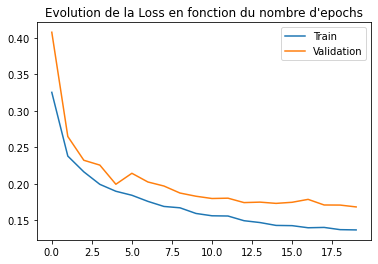

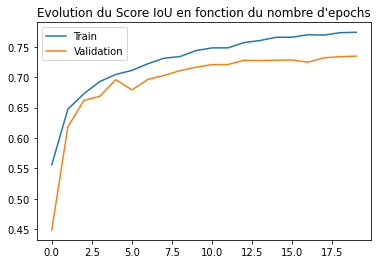

In [143]:
plot_results(metrics_10)

In [144]:
print('Nombre de paramètres du réseau : ', metrics_10['Nombre de paramètres'][0])

Nombre de paramètres du réseau :  13919792


#### Temps de calcul = 2h 15mns

#### Conclusion :
- **La modification de l'architecture a été bénéfique : l'architecture FPN a amélioré l'apprentissage**
- Le score IoU sur le jeu de validation a progressé à 0.735
- Le nombre de paramètres a diminué
- Le temps d'exécution (2h15mns) est largement inférieur au précédent (3h05mns)
- Il n'y a pas d'overfitting (écart de seulement 0.04 entre le score IoU sur le jeu d'entrainement et le jeu de validation à la dernière epoch)
> **C'est le meilleur modèle à ce stade**

### 11 - Modèle : Architecture Linket - Fonction de perte DiceLoss - Backbone Efficientnet - Poids Imagenet
- Dans ce modèle nous avons changé l'architecture pour une architecture de type Linknet

#### Création de l'expérimentation

In [151]:
experiment_name = '11_cityscape_sm_linknet_aug_efficientnet_imagenet_diceloss'

In [152]:
experiment = Experiment(workspace=ws, name=experiment_name)

#### Lancement du script

In [153]:
src = ScriptRunConfig(source_directory=project_folder, 
                      script='11_train_sm_linknet_aug_efficientnet_imagenet_diceloss.py',
                      arguments=script_arguments,
                      compute_target=compute, 
                      environment=environment)

In [154]:
run_11 = experiment.submit(config=src)

In [155]:
run_11

Experiment,Id,Type,Status,Details Page,Docs Page
11_cityscape_sm_linknet_aug_efficientnet_imagenet_diceloss,11_cityscape_sm_linknet_aug_efficientnet_imagenet_diceloss_1633513851_cda9eb39,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [156]:
%%time
# Shows output of the run on stdout.
run_11.wait_for_completion(show_output=True)

RunId: 11_cityscape_sm_linknet_aug_efficientnet_imagenet_diceloss_1633513851_cda9eb39
Web View: https://ml.azure.com/runs/11_cityscape_sm_linknet_aug_efficientnet_imagenet_diceloss_1633513851_cda9eb39?wsid=/subscriptions/dc0050bb-8e50-4b60-8aac-034371ba1a2a/resourcegroups/OC-IA-P8-GPU/workspaces/WS-IA-P8-GPU&tid=894ad120-c276-4dfa-b218-d82b3fece6a7

Streaming azureml-logs/55_azureml-execution-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

2021-10-06T09:51:02Z Running following command: /bin/bash -c sudo blobfuse /mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/11_cityscape_sm_linknet_aug_efficientnet_imagenet_diceloss_1633513851_cda9eb39/mounts/workspaceblobstore --tmp-path=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/11_cityscape_sm_linknet_aug_efficientnet_imagenet_diceloss_1633513851_cda9eb39/caches/workspaceblobstore -o ro --file-cache-timeout-in-seconds=1000000 --cache-size-mb=252733 -o nonempty -o allow_other --config-file=/mnt

Epoch 1/20
2021-10-06 09:52:02.419922: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-10-06 09:52:03.101690: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10

74/74 [==============================] - ETA: 0s - loss: 0.4971 - iou_score: 0.3900
Epoch 00001: val_loss improved from inf to 0.66921, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 572s 8s/step - loss: 0.4971 - iou_score: 0.3900 - val_loss: 0.6692 - val_iou_score: 0.2319
Epoch 2/20

24/74 [========>.....................] - ETA: 3:09 - loss: 0.3110 - iou_score: 0.5756


74/74 [==============================] - ETA: 0s - loss: 0.2883 - iou_score: 0.5991
Epoch 00002: val_loss improved from 0.66921 to 0.30740, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 347s 5s/step - loss: 0.2883 - iou_score: 0.5991 - val_loss: 0.3074 - val_iou_score: 0.5725
Epoch 3/20

57/74 [======================>.......] - ETA: 1:05 - loss: 0.2462 - iou_score: 0.6401


74/74 [==============================] - ETA: 0s - loss: 0.2427 - iou_score: 0.6438
Epoch 00003: val_loss improved from 0.30740 to 0.28832, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 345s 5s/step - loss: 0.2427 - iou_score: 0.6438 - val_loss: 0.2883 - val_iou_score: 0.5940
Epoch 4/20

74/74 [==============================] - ETA: 0s - loss: 0.2195 - iou_score: 0.6703
Epoch 00004: val_loss improved from 0.28832 to 0.22344, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 347s 5s/step - loss: 0.2195 - iou_score: 0.6703 - val_loss: 0.2234 - val_iou_score: 0.6679
Epoch 5/20

 5/74 [=>............................] - ETA: 3:37 - loss: 0.2173 - iou_score: 0.6703


74/74 [==============================] - ETA: 0s - loss: 0.2068 - iou_score: 0.6853
Epoch 00005: val_loss improved from 0.22344 to 0.21513, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 345s 5s/step - loss: 0.2068 - iou_score: 0.6853 - val_loss: 0.2151 - val_iou_score: 0.6804
Epoch 6/20

38/74 [==============>...............] - ETA: 2:19 - loss: 0.1977 - iou_score: 0.6958


74/74 [==============================] - ETA: 0s - loss: 0.1991 - iou_score: 0.6943
Epoch 00006: val_loss did not improve from 0.21513

74/74 [==============================] - 345s 5s/step - loss: 0.1991 - iou_score: 0.6943 - val_loss: 0.2227 - val_iou_score: 0.6666
Epoch 7/20

60/74 [=======================>......] - ETA: 54s - loss: 0.1892 - iou_score: 0.7069


74/74 [==============================] - ETA: 0s - loss: 0.1897 - iou_score: 0.7062
Epoch 00007: val_loss improved from 0.21513 to 0.20102, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 345s 5s/step - loss: 0.1897 - iou_score: 0.7062 - val_loss: 0.2010 - val_iou_score: 0.6964
Epoch 8/20

74/74 [==============================] - ETA: 0s - loss: 0.1868 - iou_score: 0.7098
Epoch 00008: val_loss improved from 0.20102 to 0.19857, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 344s 5s/step - loss: 0.1868 - iou_score: 0.7098 - val_loss: 0.1986 - val_iou_score: 0.6983
Epoch 9/20

 5/74 [=>............................] - ETA: 3:41 - loss: 0.1818 - iou_score: 0.7131


74/74 [==============================] - ETA: 0s - loss: 0.1829 - iou_score: 0.7147
Epoch 00009: val_loss improved from 0.19857 to 0.19513, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 344s 5s/step - loss: 0.1829 - iou_score: 0.7147 - val_loss: 0.1951 - val_iou_score: 0.7038
Epoch 10/20

28/74 [==========>...................] - ETA: 2:55 - loss: 0.1853 - iou_score: 0.7126


74/74 [==============================] - ETA: 0s - loss: 0.1814 - iou_score: 0.7166
Epoch 00010: val_loss improved from 0.19513 to 0.19147, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 344s 5s/step - loss: 0.1814 - iou_score: 0.7166 - val_loss: 0.1915 - val_iou_score: 0.7072
Epoch 11/20

61/74 [=======================>......] - ETA: 50s - loss: 0.1750 - iou_score: 0.7247


74/74 [==============================] - ETA: 0s - loss: 0.1756 - iou_score: 0.7238
Epoch 00011: val_loss did not improve from 0.19147

74/74 [==============================] - 342s 5s/step - loss: 0.1756 - iou_score: 0.7238 - val_loss: 0.1962 - val_iou_score: 0.7030
Epoch 12/20

74/74 [==============================] - ETA: 0s - loss: 0.1728 - iou_score: 0.7274
Epoch 00012: val_loss did not improve from 0.19147

74/74 [==============================] - 343s 5s/step - loss: 0.1728 - iou_score: 0.7274 - val_loss: 0.1945 - val_iou_score: 0.7052
Epoch 13/20

11/74 [===>..........................] - ETA: 3:47 - loss: 0.1690 - iou_score: 0.7312


74/74 [==============================] - ETA: 0s - loss: 0.1704 - iou_score: 0.7304
Epoch 00013: val_loss improved from 0.19147 to 0.18863, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 344s 5s/step - loss: 0.1704 - iou_score: 0.7304 - val_loss: 0.1886 - val_iou_score: 0.7110
Epoch 14/20

44/74 [================>.............] - ETA: 1:55 - loss: 0.1653 - iou_score: 0.7374


74/74 [==============================] - ETA: 0s - loss: 0.1671 - iou_score: 0.7349
Epoch 00014: val_loss improved from 0.18863 to 0.18819, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 344s 5s/step - loss: 0.1671 - iou_score: 0.7349 - val_loss: 0.1882 - val_iou_score: 0.7134
Epoch 15/20

67/74 [==========================>...] - ETA: 27s - loss: 0.1653 - iou_score: 0.7370


74/74 [==============================] - ETA: 0s - loss: 0.1648 - iou_score: 0.7378
Epoch 00015: val_loss improved from 0.18819 to 0.18799, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 344s 5s/step - loss: 0.1648 - iou_score: 0.7378 - val_loss: 0.1880 - val_iou_score: 0.7128
Epoch 16/20

74/74 [==============================] - ETA: 0s - loss: 0.1630 - iou_score: 0.7403
Epoch 00016: val_loss improved from 0.18799 to 0.18428, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 344s 5s/step - loss: 0.1630 - iou_score: 0.7403 - val_loss: 0.1843 - val_iou_score: 0.7175
Epoch 17/20

12/74 [===>..........................] - ETA: 3:42 - loss: 0.1523 - iou_score: 0.7554


74/74 [==============================] - ETA: 0s - loss: 0.1590 - iou_score: 0.7455
Epoch 00017: val_loss improved from 0.18428 to 0.18122, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 344s 5s/step - loss: 0.1590 - iou_score: 0.7455 - val_loss: 0.1812 - val_iou_score: 0.7208
Epoch 18/20

34/74 [============>.................] - ETA: 2:33 - loss: 0.1600 - iou_score: 0.7440


74/74 [==============================] - ETA: 0s - loss: 0.1592 - iou_score: 0.7452
Epoch 00018: val_loss improved from 0.18122 to 0.17909, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 344s 5s/step - loss: 0.1592 - iou_score: 0.7452 - val_loss: 0.1791 - val_iou_score: 0.7233
Epoch 19/20

57/74 [======================>.......] - ETA: 1:05 - loss: 0.1568 - iou_score: 0.7484


74/74 [==============================] - ETA: 0s - loss: 0.1568 - iou_score: 0.7484
Epoch 00019: val_loss improved from 0.17909 to 0.17716, saving model to cityscape-sm-linknet-aug-efficientnet-imagenet-diceloss.h5

74/74 [==============================] - 344s 5s/step - loss: 0.1568 - iou_score: 0.7484 - val_loss: 0.1772 - val_iou_score: 0.7251
Epoch 20/20

74/74 [==============================] - ETA: 0s - loss: 0.1541 - iou_score: 0.7518

Streaming azureml-logs/75_job_post-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

[2021-10-06T11:52:15.207410] Entering job release
[2021-10-06T11:52:16.027440] Starting job release
[2021-10-06T11:52:16.027879] Logging experiment finalizing status in history service.
Starting the daemon thread to refresh tokens in background for process with pid = 992[2021-10-06T11:52:16.028133] job release stage : upload_datastore starting...

[2021-10-06T11:52:16.029054] job release stage : start importing azureml.history._tracking


Execution Summary
RunId: 11_cityscape_sm_linknet_aug_efficientnet_imagenet_diceloss_1633513851_cda9eb39
Web View: https://ml.azure.com/runs/11_cityscape_sm_linknet_aug_efficientnet_imagenet_diceloss_1633513851_cda9eb39?wsid=/subscriptions/dc0050bb-8e50-4b60-8aac-034371ba1a2a/resourcegroups/OC-IA-P8-GPU/workspaces/WS-IA-P8-GPU&tid=894ad120-c276-4dfa-b218-d82b3fece6a7

Wall time: 2h 2min 31s


{'runId': '11_cityscape_sm_linknet_aug_efficientnet_imagenet_diceloss_1633513851_cda9eb39',
 'target': 'obonheur1',
 'status': 'Completed',
 'startTimeUtc': '2021-10-06T09:51:01.236867Z',
 'endTimeUtc': '2021-10-06T11:52:26.853071Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'e2ee7da1-6158-458e-a07d-32ddd8e8a513',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '04ea4a17-f1ee-4144-a1b2-d352f7bf27f6'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__04ea4a17', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': '11_train_sm_linknet_aug_efficientnet_imagenet_diceloss.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-path', 'DatasetConsumptionConfig:input__04ea4a17'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target':

#### Résultats

In [157]:
metrics_11 = run_11.get_metrics()

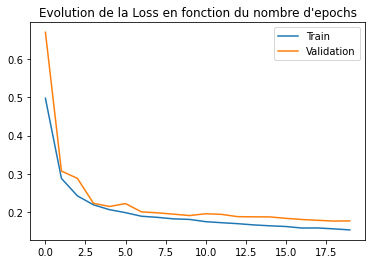

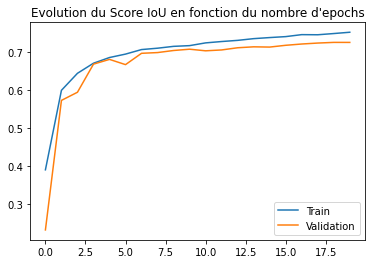

In [158]:
plot_results(metrics_11)

In [159]:
print('Nombre de paramètres du réseau : ', metrics_11['Nombre de paramètres'][0])

Nombre de paramètres du réseau :  13762000


#### Temps de calcul = 2h 01mns

#### Conclusion :
- Ce modèle est un peu moins bon que le précédent
- Le score IoU sur le jeu de validation a diminué à 0.725
- Le temps d'exécution et le nombre de paramètres sont du même ordre
- Il n'y a pas d'overfitting (écart de seulement 0.03 entre le score IoU sur le jeu d'entrainement et le jeu de validation à la dernière epoch)

### Meilleur modèle :
- Le meilleur modèle retenu est le suivant : 
    - **Augmentation des données version 1**
    - Fonction de perte **DiceLoss**
    - Backbone **Efficientnet** avec poids pré entrainés **Imagenet**
    - Architecture **FPN**
    
    
- On peut noter que **ce modèle améliore nettement le modèle de référence (baseline)** :
    - Le score IoU a progressé de 0.480 pour le modèle de référence à 0.735 pour le modèle optimisé
    - Le temps d'exécution a diminué de 2h48mns pour le modèle de référence à 2h15mns pour le modèle optimisisé

### 12 - Meilleur modèle entrainé sur des images de dimensions plus grandes
- Pour terminer la phase de modélisation, nous avons entrainé le meilleur modèle sur des images de plus grandes dimensions

#### Création de l'expérimentation

In [77]:
experiment_name = '12_cityscape_best_model'

In [78]:
experiment = Experiment(workspace=ws, name=experiment_name)

#### Lancement du script

In [87]:
src = ScriptRunConfig(source_directory=project_folder, 
                      script='12_train_best_model.py',
                      arguments=script_arguments,
                      compute_target=compute, 
                      environment=environment)

In [88]:
run_12 = experiment.submit(config=src)

In [89]:
run_12

Experiment,Id,Type,Status,Details Page,Docs Page
12_cityscape_best_model,12_cityscape_best_model_1633772940_3bb138a5,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [90]:
%%time
# Shows output of the run on stdout.
run_12.wait_for_completion(show_output=True)

RunId: 12_cityscape_best_model_1633772940_3bb138a5
Web View: https://ml.azure.com/runs/12_cityscape_best_model_1633772940_3bb138a5?wsid=/subscriptions/dc0050bb-8e50-4b60-8aac-034371ba1a2a/resourcegroups/OC-IA-P8-GPU/workspaces/WS-IA-P8-GPU&tid=894ad120-c276-4dfa-b218-d82b3fece6a7

Streaming azureml-logs/55_azureml-execution-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

2021-10-09T09:49:17Z Running following command: /bin/bash -c sudo blobfuse /mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/12_cityscape_best_model_1633772940_3bb138a5/mounts/workspaceblobstore --tmp-path=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/12_cityscape_best_model_1633772940_3bb138a5/caches/workspaceblobstore -o ro --file-cache-timeout-in-seconds=1000000 --cache-size-mb=252734 -o nonempty -o allow_other --config-file=/mnt/batch/tasks/shared/LS_root/jobs/ws-ia-p8-gpu/azureml/12_cityscape_best_model_1633772940_3bb138a5/configs/workspaceblobstore.cfg --log-level

2021-10-09 09:50:05.634057: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-10-09 09:50:06.285068: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-10-09 09:50:11.162107: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-09 09:50:12.352040: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.84GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.

  3/297 [..............................] - ETA: 7:31 - loss: 0.7146 - iou_score: 0.19492021-10-09 09:50:2

173/297 [================>.............] - ETA: 6:04 - loss: 0.2808 - iou_score: 0.6049


279/297 [===========================>..] - ETA: 53s - loss: 0.2566 - iou_score: 0.6308


297/297 [==============================] - ETA: 0s - loss: 0.2534 - iou_score: 0.6344
Epoch 00001: val_loss improved from inf to 0.25833, saving model to cityscape-best-model.h5

297/297 [==============================] - 990s 3s/step - loss: 0.2534 - iou_score: 0.6344 - val_loss: 0.2583 - val_iou_score: 0.6368
Epoch 2/20

 77/297 [======>.......................] - ETA: 9:07 - loss: 0.1955 - iou_score: 0.6996


173/297 [================>.............] - ETA: 5:10 - loss: 0.1906 - iou_score: 0.7056


275/297 [==========================>...] - ETA: 54s - loss: 0.1883 - iou_score: 0.7088


297/297 [==============================] - ETA: 0s - loss: 0.1879 - iou_score: 0.7093
Epoch 00002: val_loss improved from 0.25833 to 0.19307, saving model to cityscape-best-model.h5

297/297 [==============================] - 804s 3s/step - loss: 0.1879 - iou_score: 0.7093 - val_loss: 0.1931 - val_iou_score: 0.7074
Epoch 3/20

 74/297 [======>.......................] - ETA: 9:10 - loss: 0.1751 - iou_score: 0.7261


170/297 [================>.............] - ETA: 5:15 - loss: 0.1710 - iou_score: 0.7307


272/297 [==========================>...] - ETA: 1:02 - loss: 0.1728 - iou_score: 0.7281


297/297 [==============================] - ETA: 0s - loss: 0.1716 - iou_score: 0.7300
Epoch 00003: val_loss improved from 0.19307 to 0.16538, saving model to cityscape-best-model.h5

297/297 [==============================] - 800s 3s/step - loss: 0.1716 - iou_score: 0.7300 - val_loss: 0.1654 - val_iou_score: 0.7404
Epoch 4/20

 71/297 [======>.......................] - ETA: 9:18 - loss: 0.1596 - iou_score: 0.7438


167/297 [===============>..............] - ETA: 5:23 - loss: 0.1615 - iou_score: 0.7417


269/297 [==========================>...] - ETA: 1:09 - loss: 0.1619 - iou_score: 0.7424


297/297 [==============================] - ETA: 0s - loss: 0.1618 - iou_score: 0.7427
Epoch 00004: val_loss did not improve from 0.16538

297/297 [==============================] - 800s 3s/step - loss: 0.1618 - iou_score: 0.7427 - val_loss: 0.1778 - val_iou_score: 0.7278
Epoch 5/20

 68/297 [=====>........................] - ETA: 9:27 - loss: 0.1614 - iou_score: 0.7427


164/297 [===============>..............] - ETA: 5:31 - loss: 0.1564 - iou_score: 0.7492


266/297 [=========================>....] - ETA: 1:17 - loss: 0.1533 - iou_score: 0.7536


297/297 [==============================] - ETA: 0s - loss: 0.1531 - iou_score: 0.7540
Epoch 00005: val_loss did not improve from 0.16538

297/297 [==============================] - 804s 3s/step - loss: 0.1531 - iou_score: 0.7540 - val_loss: 0.1658 - val_iou_score: 0.7424
Epoch 6/20

 64/297 [=====>........................] - ETA: 9:30 - loss: 0.1450 - iou_score: 0.7652


160/297 [===============>..............] - ETA: 5:40 - loss: 0.1442 - iou_score: 0.7658


262/297 [=========================>....] - ETA: 1:27 - loss: 0.1442 - iou_score: 0.7661


297/297 [==============================] - ETA: 0s - loss: 0.1452 - iou_score: 0.7647
Epoch 00006: val_loss improved from 0.16538 to 0.15569, saving model to cityscape-best-model.h5

297/297 [==============================] - 802s 3s/step - loss: 0.1452 - iou_score: 0.7647 - val_loss: 0.1557 - val_iou_score: 0.7537
Epoch 7/20

 61/297 [=====>........................] - ETA: 9:38 - loss: 0.1391 - iou_score: 0.7719


163/297 [===============>..............] - ETA: 5:32 - loss: 0.1413 - iou_score: 0.7702


259/297 [=========================>....] - ETA: 1:34 - loss: 0.1429 - iou_score: 0.7680


297/297 [==============================] - ETA: 0s - loss: 0.1425 - iou_score: 0.7686
Epoch 00007: val_loss did not improve from 0.15569

297/297 [==============================] - 800s 3s/step - loss: 0.1425 - iou_score: 0.7686 - val_loss: 0.1594 - val_iou_score: 0.7496
Epoch 8/20

 65/297 [=====>........................] - ETA: 9:28 - loss: 0.1399 - iou_score: 0.7717


167/297 [===============>..............] - ETA: 5:22 - loss: 0.1415 - iou_score: 0.7695


263/297 [=========================>....] - ETA: 1:24 - loss: 0.1415 - iou_score: 0.7696


297/297 [==============================] - ETA: 0s - loss: 0.1405 - iou_score: 0.7709
Epoch 00008: val_loss improved from 0.15569 to 0.15177, saving model to cityscape-best-model.h5

297/297 [==============================] - 802s 3s/step - loss: 0.1405 - iou_score: 0.7709 - val_loss: 0.1518 - val_iou_score: 0.7582
Epoch 9/20

 67/297 [=====>........................] - ETA: 9:28 - loss: 0.1345 - iou_score: 0.7791


163/297 [===============>..............] - ETA: 5:33 - loss: 0.1337 - iou_score: 0.7807


265/297 [=========================>....] - ETA: 1:19 - loss: 0.1347 - iou_score: 0.7793


297/297 [==============================] - ETA: 0s - loss: 0.1340 - iou_score: 0.7802
Epoch 00009: val_loss did not improve from 0.15177

297/297 [==============================] - 801s 3s/step - loss: 0.1340 - iou_score: 0.7802 - val_loss: 0.1568 - val_iou_score: 0.7525
Epoch 10/20

 64/297 [=====>........................] - ETA: 9:36 - loss: 0.1324 - iou_score: 0.7822


160/297 [===============>..............] - ETA: 5:41 - loss: 0.1323 - iou_score: 0.7825


261/297 [=========================>....] - ETA: 1:30 - loss: 0.1315 - iou_score: 0.7835


297/297 [==============================] - ETA: 0s - loss: 0.1319 - iou_score: 0.7828
Epoch 00010: val_loss improved from 0.15177 to 0.14833, saving model to cityscape-best-model.h5

297/297 [==============================] - 805s 3s/step - loss: 0.1319 - iou_score: 0.7828 - val_loss: 0.1483 - val_iou_score: 0.7635
Epoch 11/20

 59/297 [====>.........................] - ETA: 9:48 - loss: 0.1327 - iou_score: 0.7809


161/297 [===============>..............] - ETA: 5:38 - loss: 0.1346 - iou_score: 0.7783


257/297 [========================>.....] - ETA: 1:39 - loss: 0.1330 - iou_score: 0.7809


297/297 [==============================] - ETA: 0s - loss: 0.1337 - iou_score: 0.7800
Epoch 00011: val_loss did not improve from 0.14833

297/297 [==============================] - 803s 3s/step - loss: 0.1337 - iou_score: 0.7800 - val_loss: 0.1532 - val_iou_score: 0.7573
Epoch 12/20

 62/297 [=====>........................] - ETA: 9:38 - loss: 0.1271 - iou_score: 0.7899


164/297 [===============>..............] - ETA: 5:31 - loss: 0.1305 - iou_score: 0.7849


259/297 [=========================>....] - ETA: 1:35 - loss: 0.1301 - iou_score: 0.7853


297/297 [==============================] - ETA: 0s - loss: 0.1293 - iou_score: 0.7863
Epoch 00012: val_loss did not improve from 0.14833

297/297 [==============================] - 802s 3s/step - loss: 0.1293 - iou_score: 0.7863 - val_loss: 0.1542 - val_iou_score: 0.7556
Epoch 13/20

 64/297 [=====>........................] - ETA: 9:36 - loss: 0.1343 - iou_score: 0.7796


161/297 [===============>..............] - ETA: 5:38 - loss: 0.1296 - iou_score: 0.7855


262/297 [=========================>....] - ETA: 1:27 - loss: 0.1298 - iou_score: 0.7853


297/297 [==============================] - ETA: 0s - loss: 0.1302 - iou_score: 0.7848
Epoch 00013: val_loss did not improve from 0.14833

297/297 [==============================] - 802s 3s/step - loss: 0.1302 - iou_score: 0.7848 - val_loss: 0.1617 - val_iou_score: 0.7458
Epoch 14/20

 67/297 [=====>........................] - ETA: 9:27 - loss: 0.1366 - iou_score: 0.7775


164/297 [===============>..............] - ETA: 5:30 - loss: 0.1293 - iou_score: 0.7865


266/297 [=========================>....] - ETA: 1:17 - loss: 0.1292 - iou_score: 0.7862


297/297 [==============================] - ETA: 0s - loss: 0.1289 - iou_score: 0.7867
Epoch 00014: val_loss improved from 0.14833 to 0.14818, saving model to cityscape-best-model.h5

297/297 [==============================] - 802s 3s/step - loss: 0.1289 - iou_score: 0.7867 - val_loss: 0.1482 - val_iou_score: 0.7614
Epoch 15/20

 64/297 [=====>........................] - ETA: 9:36 - loss: 0.1240 - iou_score: 0.7924


166/297 [===============>..............] - ETA: 5:25 - loss: 0.1258 - iou_score: 0.7907


268/297 [==========================>...] - ETA: 1:12 - loss: 0.1250 - iou_score: 0.7922


297/297 [==============================] - ETA: 0s - loss: 0.1247 - iou_score: 0.7927
Epoch 00015: val_loss improved from 0.14818 to 0.13898, saving model to cityscape-best-model.h5

297/297 [==============================] - 803s 3s/step - loss: 0.1247 - iou_score: 0.7927 - val_loss: 0.1390 - val_iou_score: 0.7752
Epoch 16/20

 67/297 [=====>........................] - ETA: 9:25 - loss: 0.1204 - iou_score: 0.7989


169/297 [================>.............] - ETA: 5:17 - loss: 0.1203 - iou_score: 0.7986


277/297 [==========================>...] - ETA: 49s - loss: 0.1223 - iou_score: 0.7961


297/297 [==============================] - ETA: 0s - loss: 0.1222 - iou_score: 0.7961
Epoch 00016: val_loss did not improve from 0.13898

297/297 [==============================] - 800s 3s/step - loss: 0.1222 - iou_score: 0.7961 - val_loss: 0.1488 - val_iou_score: 0.7633
Epoch 17/20

 82/297 [=======>......................] - ETA: 8:52 - loss: 0.1176 - iou_score: 0.8028


184/297 [=================>............] - ETA: 4:41 - loss: 0.1199 - iou_score: 0.7996


286/297 [===========================>..] - ETA: 27s - loss: 0.1195 - iou_score: 0.8000


297/297 [==============================] - ETA: 0s - loss: 0.1194 - iou_score: 0.8001
Epoch 00017: val_loss improved from 0.13898 to 0.13872, saving model to cityscape-best-model.h5

297/297 [==============================] - 803s 3s/step - loss: 0.1194 - iou_score: 0.8001 - val_loss: 0.1387 - val_iou_score: 0.7758
Epoch 18/20

 91/297 [========>.....................] - ETA: 8:29 - loss: 0.1157 - iou_score: 0.8046


187/297 [=================>............] - ETA: 4:33 - loss: 0.1164 - iou_score: 0.8040


289/297 [============================>.] - ETA: 19s - loss: 0.1190 - iou_score: 0.8007


297/297 [==============================] - ETA: 0s - loss: 0.1195 - iou_score: 0.8002
Epoch 00018: val_loss did not improve from 0.13872

297/297 [==============================] - 802s 3s/step - loss: 0.1195 - iou_score: 0.8002 - val_loss: 0.1419 - val_iou_score: 0.7710
Epoch 19/20

 94/297 [========>.....................] - ETA: 8:20 - loss: 0.1181 - iou_score: 0.8017


196/297 [==================>...........] - ETA: 4:11 - loss: 0.1163 - iou_score: 0.8044


297/297 [==============================] - ETA: 0s - loss: 0.1154 - iou_score: 0.8058


Epoch 00019: val_loss improved from 0.13872 to 0.13218, saving model to cityscape-best-model.h5

297/297 [==============================] - 804s 3s/step - loss: 0.1154 - iou_score: 0.8058 - val_loss: 0.1322 - val_iou_score: 0.7846
Epoch 20/20

 96/297 [========>.....................] - ETA: 8:17 - loss: 0.1143 - iou_score: 0.8074


198/297 [===================>..........] - ETA: 4:06 - loss: 0.1155 - iou_score: 0.8057


297/297 [==============================] - ETA: 0s - loss: 0.1137 - iou_score: 0.8083



Streaming azureml-logs/75_job_post-tvmps_804db8d9d167b6b68e52ef82f75d4bdbdc1d86957392f98487a968916476d8fc_d.txt

[2021-10-09T14:21:50.115231] Entering job release
[2021-10-09T14:21:50.920218] Starting job release
[2021-10-09T14:21:50.920624] Logging experiment finalizing status in history service.
[2021-10-09T14:21:50.920820] job release stage : upload_datastore starting...Starting the daemon thread to refresh tokens in background for process with pid = 1932

[2021-10-09T14:21:50.921588] job release stage : start importing azureml.history._tracking in run_history_release.
[2021-10-09T14:21:50.921947] job release stage : execute_job_release starting...[2021-10-09T14:21:50.922088] job release stage : copy_batchai_cached_logs starting...

[2021-10-09T14:21:50.924143] job release stage : copy_batchai_cached_logs completed...
[2021-10-09T14:21:50.935339] Entering context manager injector.
[2021-10-09T14:21:50.939732] job release stage : upload_datastore completed...
[2021-10-09T14:21:51.00

{'runId': '12_cityscape_best_model_1633772940_3bb138a5',
 'target': 'obonheur1',
 'status': 'Completed',
 'startTimeUtc': '2021-10-09T09:49:15.604988Z',
 'endTimeUtc': '2021-10-09T14:22:01.638537Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '33caeb29-4e39-45fd-a851-5dea60d8278f',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '04ea4a17-f1ee-4144-a1b2-d352f7bf27f6'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__04ea4a17', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': '12_train_best_model.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-path', 'DatasetConsumptionConfig:input__04ea4a17'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'obonheur1',
  'dataReferences': {},
  'data': {'input__04ea4a17': {'

#### Résultats

In [91]:
metrics_12 = run_12.get_metrics()

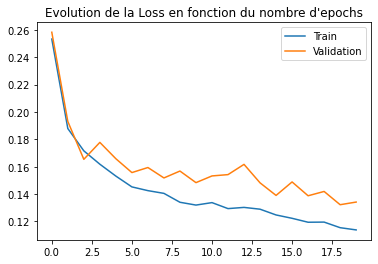

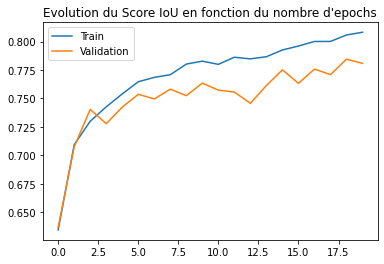

In [92]:
plot_results(metrics_12)

In [93]:
print('Nombre de paramètres du réseau : ', metrics_12['Nombre de paramètres'][0])

Nombre de paramètres du réseau :  13919792


#### Temps de calcul = 4h 32mns

#### Conclusion :
- L'augmentation de la taille des images a amélioré le résultat
- Le score IoU sur le jeu de validation a nettement augmenté à 0.781
- Il n'y a pas d'overfitting (écart de seulement 0.03 entre le score IoU sur le jeu d'entrainement et le jeu de validation à la dernière epoch)

## Conclusion de la modélisation :
- Nous obtenons un **score IoU sur le jeu de validation de 0.781**, ce qui peut être considéré comme un **très bon résultat**

# Evaluation du meilleur modèle sur le jeu de test

## Récupération du meilleur modèle dans Azure

In [94]:
best_model_name = 'cityscape-best-model.h5'
custom_objects = {'iou_score': sm.metrics.iou_score, 'dice_loss': sm.losses.dice_loss}
best_model_obj = Model(ws, best_model_name)
best_model_path = best_model_obj.download(target_dir='./models', exist_ok = True)
best_model = load_model(best_model_path, custom_objects=custom_objects)

## Générateur et pre processing pour le jeu de test

In [95]:
BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [96]:
#Fonction de preprocessing
def get_preprocessing(preprocessing_fn):   
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [97]:
# Génération des données
class DataGeneratorKeras(Sequence):

    def __init__(self, batch_size, img_size, input_img_dir, target_img_dir, preprocessing):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_dir = input_img_dir
        self.input_img_paths = os.listdir(input_img_dir)
        self.target_img_dir = target_img_dir
        self.target_img_paths = os.listdir(target_img_dir)
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
                
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (8,), dtype="float32")
        
        #traitement des images
        for j, input_path in enumerate(batch_input_img_paths):
            img = load_img(os.path.join(self.input_img_dir, input_path), target_size=self.img_size)
            img_array = img_to_array(img)
            preprocessed_image = self.preprocessing(image=img_array)
            x[j] = preprocessed_image['image']
        
        #traitement des masques
        for j, target_path in enumerate(batch_target_img_paths):
            mask = load_img(os.path.join(self.target_img_dir, target_path), target_size=self.img_size, color_mode="grayscale")
            mask_array = np.squeeze(img_to_array(mask))
            y[j] = tf.one_hot(mask_array, 8, on_value=1.0, off_value=0.0, axis=-1)

        return x, y

In [98]:
image_dataset_test_dir = './cityscape/prepared_data/images/test'
mask_dataset_test_dir = './cityscape/prepared_data/masks/test'

In [99]:
img_size = (256, 512)

In [100]:
test_gen = DataGeneratorKeras(5, img_size, image_dataset_test_dir, mask_dataset_test_dir, get_preprocessing(preprocess_input))

## Prédictions sur le jeu de test

In [101]:
test_predictions = best_model.predict(test_gen, verbose=1)

100/100 [==============================] - 611s 6s/step


## Calcul du Score IoU sur le jeu de test

In [102]:
masks_predicted_array = np.argmax(test_predictions, axis=-1)

In [103]:
masks_to_predict_array = np.zeros(masks_predicted_array.shape, dtype="int64")

In [104]:
for i, img in enumerate(os.listdir(mask_dataset_test_dir)):
    mask_load = load_img(os.path.join(mask_dataset_test_dir, img), target_size=img_size)
    mask_array = img_to_array(mask_load)
    masks_to_predict_array[i]=mask_array[:,:,0]

In [105]:
m = tf.keras.metrics.MeanIoU(num_classes=8)
m.update_state(masks_to_predict_array, masks_predicted_array)
test_score_iou = m.result().numpy()

In [106]:
print(f'Score IoU sur le jeu de test = {test_score_iou:.3f}')

Score IoU sur le jeu de test = 0.778


## Conclusion de l'évaluation sur le jeu de test :
- On obtient un score IoU sur le jeu de test égal à 0.778
- Ce score est très proche de celui obtenu lors de la modélisation sur le jeu de validation (0.781) 
- **Cela montre la qualité et la bonne capacité de généralisation de notre modèle**